[Task 1](#Task-1)

[1.1 Multi-layer perceptron](#1.1-Multi-layer-pereceptron)

[1.1.1 Numpy implementation](#1.1.1-Numpy-implementation)

[1.1.2 Different learning rates](#1.1.2-Different-learning-rates)

[1.1.3 More epochs](#1.1.3-More-epochs)

[1.2 Convolutional neural network](#1.2-Convolutional-neural-network)

[1.2.1 Using TensorFlow](#1.2.1-Using-TensorFlow)

[1.2.2 L2 Regularisation](#1.2.2-L2-Regularisation)

[1.2.3 Dropout](#1.2.3-Dropout)

[1.2.4 Comparison](#1.2.4-Comparison)

[Task 2](#Task-2)

[2.1 Clustering of the feature matrix](#2.1-Clustering-of-the-feature-matrix)

[2.1.1 K Means](#2.1.1-K-Means)

[2.1.2 Calinski Harabasz score](#2.1.2-Calinski-Harabasz-score)

[2.1.3 Robustness of the selection of $k$](#2.1.3-Robustness-of-the-selection-of-k)

[2.2.1 PCA d = 1, 2, 3](#2.2.1-PCA-d-=-1,-2,-3)

[2.2.2 Variance explained](#2.2.2-Variance-explained)

[2.3 Graph-based analysis](#2.3-Graph-based-analysis)

[2.3.1 Centralities](#2.3.1-Centralities)

[2.3.2 Community detection](#2.3.2-Community-detection)

[2.3.3 Comparison of clusters (ARI)](#2.3.3-Comparison-of-clusters-(ARI))

[Task 3](#Task-3)

[3.1 Louvain algorithm for community detection](#3.1-Louvain-algorithm-for-community-detection)

[3.2 Modularity maximisation with spectral partitioning](#3.2-Modularity-maximisation-with-spectral-partitioning)

[3.2.1 Bipartitioning algorithm](#3.2.1-Bipartitioning-algorithm)

[3.2.2 Comparison of graph clustering](#3.2.2-Comparison-of-graph-clustering)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import scipy as sp
from IPython.core.display import display, HTML
from scipy.special import softmax
from scipy.sparse import linalg
import community as community_louvain
import seaborn as sns
from scipy.linalg import eigh
import warnings
warnings.filterwarnings('ignore')
from time import time
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, MaxPool2D, Dense,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
display(HTML("<style>.container { width:95% !important; }</style>"))

# Task 1

In [94]:
def load_data ():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype( 'float32' ) / 255
    x_val = x_val.astype( 'float32' ) / 255
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes= 10 )
    y_val = tf.keras.utils.to_categorical(y_val, num_classes= 10 )
    return ((x_train, y_train), (x_val, y_val))

(x_train_total, y_train), (x_val_total, y_val) = load_data()

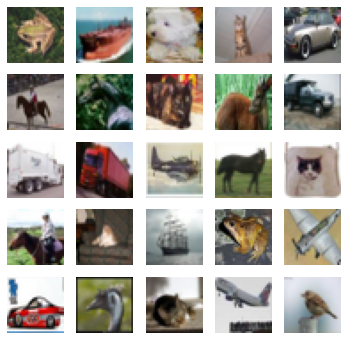

In [95]:
fig, axs = plt.subplots(5,5,figsize=(6,6))
for j in range(5):
    for i in range(5):
        axs[j,i].imshow(x_train_total[np.random.choice(range(len(x_train_total))),...])
        axs[j,i].set_axis_off()

In [99]:
print(x_train_total.shape)
print(x_val_total.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


The data consists of 50,000 color images of size 32x32, we have 10 classes that can be identified as numbers from 0 to 9. The classes are:

* 0 - airplane
* 1 - automobile
* 2 - bird
* 3 - cat
* 4 - deer
* 5 - dog
* 6 - frog
* 7 - horse
* 8 - ship
* 9 - truck

The number of samples of each class is the same (5,000), we also count with a validation dataset with another 10,000 different examples

## 1.1-Multi-layer pereceptron
### 1.1.1 Numpy implementation 
The model is the following 

$X\in \mathbb{R}^{50000\times 3072}$, $y\in \mathbb{R}^{50000\times 10}$

$W_0\in\mathbb{R}^{3072\times 400}$, $W_1\in\mathbb{R}^{400\times 400}$, $W_2\in\mathbb{R}^{400\times 400}$, $W_3\in\mathbb{R}^{400\times 400}$, $W_4\in\mathbb{R}^{400\times 400}$, $W_5\in\mathbb{R}^{400\times 10}$

$b_0\in\mathbb{R}^{400}$, $b_1\in\mathbb{R}^{400}$, $b_2\in\mathbb{R}^{400}$, $b_3\in\mathbb{R}^{400}$, $b_4\in\mathbb{R}^{400}$, $b_5\in\mathbb{R}^{10}$

$\sigma^{0}(h) = \tanh(h)$, $\sigma^{1}(h) = \tanh(h)$, $\sigma^{2}(h) = \tanh(h)$, $\sigma^{3}(h) = \tanh(h)$, $\sigma^{4}(h) = \tanh(h)$, $\sigma^{5}(h) = \text{softmax}(h)$

We tune the parameters using the cross-entropy loss function
$\mathcal{L}(y,\hat{y}) = -\sum_{j=1}^{N}\sum_{k=1}^{10}y_{jk}\log(\hat{y}_{jk})$, this vector has entries $L_j = -\sum_{k=1}^{10}y_{jk}\log(\hat{y}_{jk})$. 

We implement stochastic gradient descent using the error backpropagation, for this we need the following computations 
$$\delta^{L+1} = \frac{\partial L_i}{\partial a ^{(L+1)}} = -\frac{\partial}{\partial a ^{(L+1)}}\sum_{k=1}^{10}y_{jk}\log(\text{softmax}(a^{(L+1)})) =y - \text{softmax}(a^{(L+1)})$$

$$\delta^{k} = (1- \tanh^2(a^{k}))(W^{k})^{\top}\delta^{k-1}$$

In this way we have the derivatives of $L_i$ with respect of the weights and biases.

We do the implementation completely using numpy notation, we first flatten our data, instead of working with (32,32,3) arrays we reshape it to a 1d array of size 3,072, we loss some spatial information in the images, but it is easier to work with

In [143]:
x_train = x_train_total[...].reshape((50000,3072))
x_val   = x_val_total[...].reshape((10000,3072))

In [152]:
def dense(x, W, b):
    """
    x: K x h_in array of inputs
    W: h_in x h_out array for kernel matrix parameters
    b: Length h_out 1-D array for bias parameters
    
    returns: K x h_out output array 
    """ 
    
    h = b + x @ W
    return h
def tanh(h):
    """
    h: an array
    
    returns: array of the activation function tanh
    """
    return(np.tanh(h))
def dtanh(h):
    """
    h: an array
    
    returns: array of the derivative of tanh
    """
    return 1 - np.square(np.tanh(h))

def backpropagate(delta, W, a):
    """
    :param delta: output error
    :param W: Weights 
    :param a: the dense 
    
    :return backpropagation:
    """
    return dtanh(a)*(delta @ W.T)

def grads(delta1,delta2,delta3,delta4,delta5,delta6,h0,h1,h2,h3,h4,h5):
    
    """
    :param deltai: numpy array
    :param hi: num_array 
    
    :return grads: numpy arrays
    """

    grad_W0 = np.mean(delta1[:, np.newaxis, :] *h0[:, :, np.newaxis],axis=0)
    grad_b0 = np.mean(delta1,axis=0)
    grad_W1 = np.mean(delta2 *h1,axis=0)
    grad_b1 = np.mean(delta2,axis=0)
    grad_W2 = np.mean(delta3 *h2,axis=0)
    grad_b2 = np.mean(delta3,axis=0)
    grad_W3 = np.mean(delta4 *h3,axis=0)
    grad_b3 = np.mean(delta4,axis=0)
    grad_W4 = np.mean(delta5 *h4,axis=0)
    grad_b4 = np.mean(delta5,axis=0)
    grad_W5 = np.mean(delta6[:, np.newaxis, :] *h5[:, :, np.newaxis],axis=0)
    grad_b5 = np.mean(delta6,axis=0)

    return grad_W0, grad_b0, grad_W1,grad_b1, grad_W2, grad_b2, grad_W3, grad_b3,grad_W4, grad_b4,grad_W5,grad_b5

def generator(x,y, size=128):
    """
    :param data: numpy array 
    :param size: size of each group
    :return:     batch 
    """
    n = len(x)
    for b in range(0,n,size):
        p = np.random.permutation(n)
        p = p[0:size]
        x_batch = x[p]
        y_batch = y[p]

        yield x_batch, y_batch

def mlp(x,W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5):
    """
    x: Nx3072 array
    
    returns: y Nx1 array 
    """
    h = dense(x, W0, b0)
    h = tanh(h)
    h = dense(h, W1, b1)
    h = tanh(h)
    h = dense(h, W2, b2)
    h = tanh(h)
    h = dense(h, W3, b3)
    h = tanh(h)
    h = dense(h, W4, b4)
    h = tanh(h)
    h = dense(h, W5, b5)
    y = softmax(h,axis=1)    

    return y
def cross_entropy(y,y_hat):
    return(- np.sum(y*np.log(y_hat))/ len(y))
def output_error(y_batch, a):
    
    # y_batch: K x 1 array of data outputs
    # a2: K x 1 array of output pre-activations
    # returns: K x 1 array of output errors 
    
    return (softmax(a,axis=1) - y_batch)
def accuracy(y,y_hat):
    return sum(np.argmax(y_hat,axis=1) == np.argmax(y,axis=1) )/ len(y_hat)
def training(X,y,X_val,y_val,epochs=40,batch_size=128,learning_rate = 0.01):
    N,m = X.shape
    _,k = y.shape
    
    var0 = 2. / (m + 400)
    W0 = np.random.randn(m, 400) * np.sqrt(var0)
    b0 = np.zeros(400)

    var1 = 2. / (400 + 400)
    W1 = np.random.randn(400, 400) * np.sqrt(var1)
    b1 = np.zeros(400)

    var2 = 2. / (400 + 400)
    W2 = np.random.randn(400, 400) * np.sqrt(var2)
    b2 = np.zeros(400)

    var3 = 2. / (400 + 400)
    W3 = np.random.randn(400, 400) * np.sqrt(var2)
    b3 = np.zeros(400)
    
    var4 = 2. / (400 + 400)
    W4 = np.random.randn(400, 400) * np.sqrt(var2)
    b4 = np.zeros(400)

    var4 = 2. / (k + 400)
    W5 = np.random.randn(400, k) * np.sqrt(var2)
    b5 = np.zeros(k)

    training_losses = []
    training_acc = []
    
    val_losses = []
    val_acc = []

    for epoch in range(epochs):
        t1 = time()
        batch_generator = generator(X,y,batch_size)
        
        for x_batch,y_batch in batch_generator:

            training_losses.append(cross_entropy(y_batch, mlp(x_batch,W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5)))
            training_acc.append(accuracy(y_batch, mlp(x_batch,W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5)))


            a1 = dense(x_batch, W0, b0)
            h1 = tanh(a1)
            a2 = dense(h1, W1, b1)
            h2 = tanh(a2)
            a3 = dense(h2, W2, b2)
            h3 = tanh(a3)
            a4 = dense(h3, W3, b3)
            h4 = tanh(a4)
            a5 = dense(h4, W4, b4)
            h5 = tanh(a5)
            a6 = dense(h5,W5,b5)
            h6 = softmax(a6,axis=1)
            
            delta6 = output_error(y_batch, a6)
            delta5 = backpropagate(delta6, W5, a5)
            delta4 = backpropagate(delta5, W4, a4)
            delta3 = backpropagate(delta4, W3, a3)
            delta2 = backpropagate(delta3, W2, a2)
            delta1 = backpropagate(delta2, W1, a1)
            
            (grad_W0, grad_b0, grad_W1,grad_b1, grad_W2, grad_b2, 
            grad_W3, grad_b3,grad_W4, grad_b4,grad_W5,grad_b5) = grads(delta1,delta2,delta3,delta4,delta5,delta6,x_batch,h1,h2,h3,h4,h5)
        
            W0 = W0 - learning_rate * grad_W0
            W1 = W1 - learning_rate * grad_W1
            W2 = W2 - learning_rate * grad_W2
            W3 = W3 - learning_rate * grad_W3
            W4 = W4 - learning_rate * grad_W4
            W5 = W5 - learning_rate * grad_W5

            b0 = b0 - learning_rate * grad_b0
            b1 = b1 - learning_rate * grad_b1
            b2 = b2 - learning_rate * grad_b2
            b3 = b3 - learning_rate * grad_b3
            b4 = b4 - learning_rate * grad_b4
            b5 = b5 - learning_rate * grad_b5
        val_losses.append(cross_entropy(y_val, mlp(X_val,W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5)))
        val_acc.append(accuracy(y_val, mlp(X_val,W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5)))
        t2 = time()
        if epoch%2 == 0:
            print(f'Epoch = {epoch+1}, Train Loss = {training_losses[-1]:.6f}, Accuracy = {training_acc[-1]*100:.3f}% , Val Loss = {val_losses[-1]:.6f}, Val Accuracy = {val_acc[-1]*100:.3f}%,, Time = {(t2-t1)/60:.3f} min')
    return(training_losses,training_acc, val_losses,val_acc,W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5 )

In [6]:
epochs=40
learning_rate = 0.01
(training_losses,training_acc,
 val_losses,val_acc,
 W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5) = training(x_train,y_train,x_val,y_val,epochs=epochs,learning_rate=learning_rate)

Epoch = 1, Train Loss = 1.849728, Accuracy = 31.250% , Val Loss = 1.887489, Val Accuracy = 34.390%,, Time = 4.198 min
Epoch = 2, Train Loss = 1.678437, Accuracy = 37.500% , Val Loss = 1.806613, Val Accuracy = 36.920%,, Time = 4.287 min
Epoch = 3, Train Loss = 1.599153, Accuracy = 49.219% , Val Loss = 1.764289, Val Accuracy = 37.710%,, Time = 4.241 min
Epoch = 4, Train Loss = 1.647060, Accuracy = 39.062% , Val Loss = 1.743332, Val Accuracy = 38.390%,, Time = 4.412 min
Epoch = 5, Train Loss = 1.657873, Accuracy = 46.094% , Val Loss = 1.710133, Val Accuracy = 39.690%,, Time = 4.262 min
Epoch = 6, Train Loss = 1.655540, Accuracy = 38.281% , Val Loss = 1.687089, Val Accuracy = 40.720%,, Time = 4.234 min
Epoch = 7, Train Loss = 1.621929, Accuracy = 45.312% , Val Loss = 1.667337, Val Accuracy = 41.500%,, Time = 4.248 min
Epoch = 8, Train Loss = 1.600345, Accuracy = 49.219% , Val Loss = 1.643832, Val Accuracy = 42.340%,, Time = 4.250 min
Epoch = 9, Train Loss = 1.625843, Accuracy = 35.938% , V

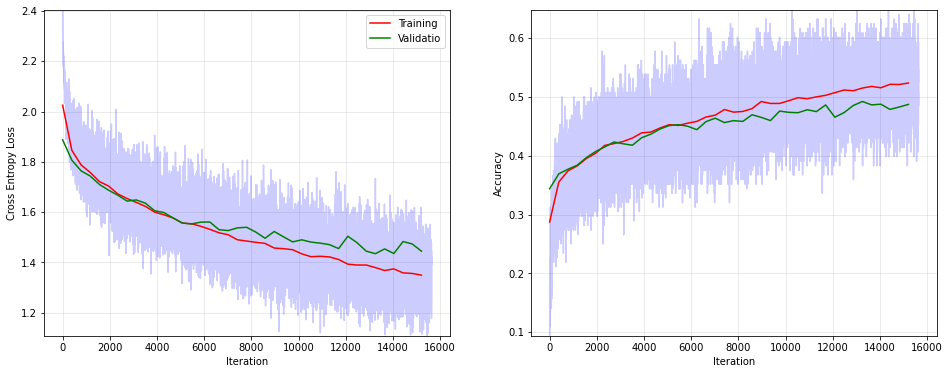

In [20]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

_ = axs[0].plot(range(len(training_losses)),training_losses,alpha=0.2,color='b')
_ = axs[0].plot(list(range(0,390*(epochs),390)),[np.array(training_losses)[(i)*390:(i+1)*390].mean() for i in range(epochs)],color='red',label='Training')
_ = axs[0].plot(list(range(0,390*(epochs),390)),val_losses,color='green',label='Validatio')
_ = axs[0].set_xlabel('Iteration')
_ = axs[0].set_ylabel('Cross Entropy Loss')
_ = axs[0].grid(alpha=0.3)
_ = axs[0].set_ylim(min(training_losses)-0.0001,max(training_losses)+0.0001)
_ = axs[0].legend()

_ = axs[1].plot(training_acc,alpha=0.2,color='b')
_ = axs[1].plot(list(range(0,390*(epochs),390)),[np.array(training_acc)[(i)*390:(i+1)*390].mean() for i in range(epochs)],color='red',label='Training')
_ = axs[1].plot(list(range(0,390*(epochs),390)),val_acc,color='green',label='Validatio')
_ = axs[1].set_xlabel('Iteration')
_ = axs[1].set_ylabel('Accuracy')
_ = axs[1].grid(alpha=0.3)
_ = axs[1].set_ylim(min(training_acc)-0.0001,max(training_acc)+0.0001)

The implementation of the algorithm was done completely translating the formulas to python/numpy language, no improvements were done. 

The results are as we expected, the loss function decreases over the epochs/iterations, the accurarcy increases over the optimization and we reach 53% in the training set and 49% in training. In the plot in red we see the evolution over the optimization of the training set, in green we see the loss an accuracy of the validation set. Aditionally the cost and accuracy was computed over the batches in the 391 iterations in each epoch, it was not a good idea because we get very noise output, that is beacuse the size of the batches is very small compared to the complete dataset, so some batches might "see" different things than what the rest of batches have seen, nonetheless the trend of the noisy pale blue curve is also as expected, the loss function decreases and the accuracy function increases.

Althought we have trend that we wanted the final accuracy could not be considered as good, most of the time the prediction is correct but the model could be improved further 53%. At the half of the optimization we find that the rate of change in both indicators is slowing down, that could mean that we have reach convergence, nonetheless we would like to have found a flatter curve. We also find an increasing gap between the validation and training curve that could mean overfitting in the parameters, althought the loss don't increase dramatically in the validation set

### 1.1.2 Different learning rates

In [9]:
epochs=40
learning_rate = 0.0001
(training_losses2,training_acc2,
 val_losses2,val_acc2,
 W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5 ) = training(x_train,y_train,x_val,y_val,epochs=epochs,learning_rate=learning_rate)

Epoch = 1, Train Loss = 2.313154, Accuracy = 8.594% , Val Loss = 2.299247, Val Accuracy = 11.560%,, Time = 4.123 min
Epoch = 2, Train Loss = 2.294439, Accuracy = 10.156% , Val Loss = 2.280073, Val Accuracy = 12.980%,, Time = 4.057 min
Epoch = 3, Train Loss = 2.273422, Accuracy = 10.938% , Val Loss = 2.268601, Val Accuracy = 14.530%,, Time = 4.088 min
Epoch = 4, Train Loss = 2.260282, Accuracy = 16.406% , Val Loss = 2.258782, Val Accuracy = 16.110%,, Time = 4.112 min
Epoch = 5, Train Loss = 2.239182, Accuracy = 15.625% , Val Loss = 2.249758, Val Accuracy = 17.770%,, Time = 4.146 min
Epoch = 6, Train Loss = 2.253684, Accuracy = 17.969% , Val Loss = 2.241138, Val Accuracy = 18.750%,, Time = 4.141 min
Epoch = 7, Train Loss = 2.206238, Accuracy = 24.219% , Val Loss = 2.232908, Val Accuracy = 19.620%,, Time = 4.159 min
Epoch = 8, Train Loss = 2.215923, Accuracy = 23.438% , Val Loss = 2.224758, Val Accuracy = 20.030%,, Time = 4.291 min
Epoch = 9, Train Loss = 2.230580, Accuracy = 22.656% , Va

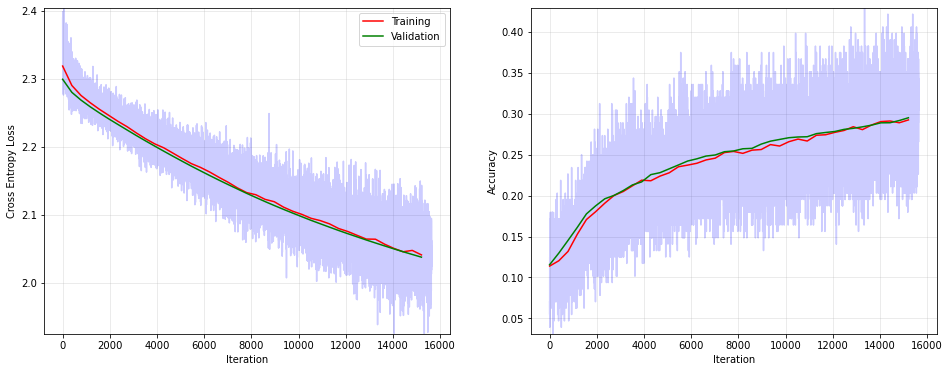

In [19]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

_ = axs[0].plot(range(len(training_losses2)),training_losses2,alpha=0.2,color='b')
_ = axs[0].plot(list(range(0,390*(epochs),390)),[np.array(training_losses2)[(i)*390:(i+1)*390].mean() for i in range(epochs)],color='red',label='Training')
_ = axs[0].plot(list(range(0,390*(epochs),390)),val_losses2,color='green',label='Validation')
_ = axs[0].set_xlabel('Iteration')
_ = axs[0].set_ylabel('Cross Entropy Loss')
_ = axs[0].grid(alpha=0.3)
_ = axs[0].set_ylim(min(training_losses2)-0.0001,max(training_losses2)+0.0001)
_ = axs[0].legend()

_ = axs[1].plot(training_acc2,alpha=0.2,color='b')
_ = axs[1].plot(list(range(0,390*(epochs),390)),[np.array(training_acc2)[(i)*390:(i+1)*390].mean() for i in range(epochs)],color='red',label='Training')
_ = axs[1].plot(list(range(0,390*(epochs),390)),val_acc2,color='green',label='Validation')
_ = axs[1].set_xlabel('Iteration')
_ = axs[1].set_ylabel('Accuracy')
_ = axs[1].grid(alpha=0.3)
_ = axs[1].set_ylim(min(training_acc2)-0.0001,max(training_acc2)+0.0001)

In [1311]:
epochs=40
learning_rate = 0.1
(training_losses3,training_acc3,
 val_losses3,val_acc3,
 W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5 ) = training(x_train,y_train,x_val,y_val,epochs=epochs,learning_rate=learning_rate)

Epoch = 1, Train Loss = 1.988949, Accuracy = 23.438% , Val Loss = 1.983602, Val Accuracy = 28.160%,, Time = 4.564 min
Epoch = 2, Train Loss = 1.882039, Accuracy = 31.250% , Val Loss = 1.879354, Val Accuracy = 34.900%,, Time = 4.294 min
Epoch = 3, Train Loss = 1.701953, Accuracy = 40.625% , Val Loss = 1.637738, Val Accuracy = 42.170%,, Time = 4.281 min
Epoch = 4, Train Loss = 1.750413, Accuracy = 32.812% , Val Loss = 1.657554, Val Accuracy = 40.810%,, Time = 4.294 min
Epoch = 5, Train Loss = 1.750292, Accuracy = 43.750% , Val Loss = 1.592705, Val Accuracy = 43.590%,, Time = 4.320 min
Epoch = 6, Train Loss = 1.609846, Accuracy = 42.969% , Val Loss = 1.536654, Val Accuracy = 45.220%,, Time = 4.737 min
Epoch = 7, Train Loss = 1.818274, Accuracy = 35.938% , Val Loss = 1.559436, Val Accuracy = 44.320%,, Time = 4.345 min
Epoch = 8, Train Loss = 1.381190, Accuracy = 50.000% , Val Loss = 1.528892, Val Accuracy = 45.210%,, Time = 4.465 min
Epoch = 9, Train Loss = 1.481209, Accuracy = 50.781% , V

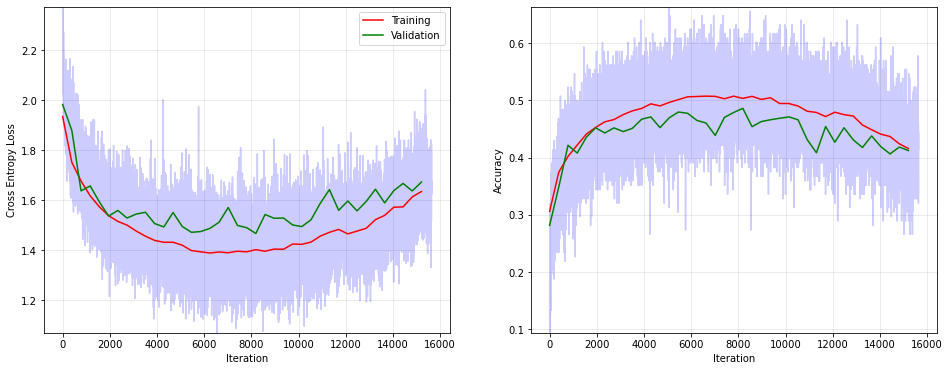

In [1312]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

_ = axs[0].plot(range(len(training_losses3)),training_losses3,alpha=0.2,color='b')
_ = axs[0].plot(list(range(0,390*(epochs),390)),[np.array(training_losses3)[(i)*390:(i+1)*390].mean() for i in range(epochs)],color='red',label='Training')
_ = axs[0].plot(list(range(0,390*(epochs),390)),val_losses3,color='green',label='Validation')
_ = axs[0].set_xlabel('Iteration')
_ = axs[0].set_ylabel('Cross Entropy Loss')
_ = axs[0].grid(alpha=0.3)
_ = axs[0].set_ylim(min(training_losses3)-0.0001,max(training_losses3)+0.0001)
_ = axs[0].legend()

_ = axs[1].plot(training_acc3,alpha=0.2,color='b')
_ = axs[1].plot(list(range(0,390*(epochs),390)),[np.array(training_acc3)[(i)*390:(i+1)*390].mean() for i in range(epochs)],color='red',label='Training')
_ = axs[1].plot(list(range(0,390*(epochs),390)),val_acc3,color='green',label='Validation')
_ = axs[1].set_xlabel('Iteration')
_ = axs[1].set_ylabel('Accuracy')
_ = axs[1].grid(alpha=0.3)
_ = axs[1].set_ylim(min(training_acc3)-0.0001,max(training_acc3)+0.0001)

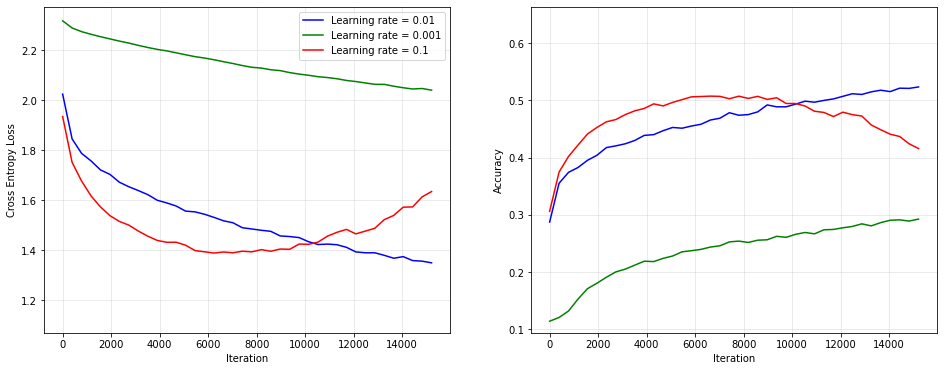

In [1324]:
fig, axs = plt.subplots(1,2,figsize=(16,6))
_ = axs[0].plot(list(range(0,390*(epochs),390)),[np.array(training_losses)[(i)*390:(i+1)*390].mean() for i in range(epochs)],
                color='blue',label='Learning rate = 0.01')
_ = axs[0].plot(list(range(0,390*(epochs),390)),[np.array(training_losses2)[(i)*390:(i+1)*390].mean() for i in range(epochs)],
                color='green',label='Learning rate = 0.001')
_ = axs[0].plot(list(range(0,390*(epochs),390)),[np.array(training_losses3)[(i)*390:(i+1)*390].mean() for i in range(epochs)],
                color='red',label='Learning rate = 0.1')
_ = axs[0].set_xlabel('Iteration')
_ = axs[0].set_ylabel('Cross Entropy Loss')
_ = axs[0].grid(alpha=0.3)
_ = axs[0].set_ylim(min(training_losses3)-0.0001,max(training_losses3)+0.0001)
_ = axs[0].legend()



_ = axs[1].plot(list(range(0,390*(epochs),390)),[np.array(training_acc)[(i)*390:(i+1)*390].mean() for i in range(epochs)],color='blue',label='Training')

_ = axs[1].plot(list(range(0,390*(epochs),390)),[np.array(training_acc2)[(i)*390:(i+1)*390].mean() for i in range(epochs)],color='green',label='Training')

_ = axs[1].plot(list(range(0,390*(epochs),390)),[np.array(training_acc3)[(i)*390:(i+1)*390].mean() for i in range(epochs)],color='red',label='Training')
_ = axs[1].set_xlabel('Iteration')
_ = axs[1].set_ylabel('Accuracy')
_ = axs[1].grid(alpha=0.3)
_ = axs[1].set_ylim(min(training_acc3)-0.0001,max(training_acc3)+0.0001)

In summary we have the results:

| Parameter|Learning rate=0.001 |Learning rate=0.01 |Learning rate=0.1 |
|--|--|--|--|
|Accuracy Training|29%|53%|42%|
|Accuracy Validation|29%|48%|42%|
|Loss Training|2.04|1.35|1.63|
|Loss Validation|2.04|1.45|1.64|

We have some interesting results, if we decrase our learning rate, as expected we see a slow convergence but as an advantage we find that the validation and training results are very close to each other over the optimization, we would like to increase the number of epochs to reach the convengence. If we increase the learning rate to 0.1 we find that the accuracy goes very fast to 50% but after reaching this point it goes down and decreases to 42%, we could not argue that the model overfits at some point beacuse the loss increases in the validation set at the same time it increases in the training set, so it could not be categorized as overfitting.  

The best selection of the 3 for learning rate is 0.01, not just by the final resul but also for the computational cost of using a small learing rate and the shape of the curves of the other 2 learning rates

### 1.1.3 More epochs

In [158]:
epochs=80
learning_rate = 0.01
(training_losses4,training_acc4,
 val_losses4,val_acc4,
 W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5 ) = training(x_train,y_train,x_val,y_val,epochs=epochs,learning_rate=learning_rate)

Epoch = 1, Train Loss = 1.887118, Accuracy = 32.031% , Val Loss = 1.910333, Val Accuracy = 33.430%,, Time = 4.403 min
Epoch = 3, Train Loss = 1.748810, Accuracy = 38.281% , Val Loss = 1.777077, Val Accuracy = 37.550%,, Time = 4.316 min
Epoch = 5, Train Loss = 1.651878, Accuracy = 39.844% , Val Loss = 1.716610, Val Accuracy = 39.640%,, Time = 4.401 min
Epoch = 7, Train Loss = 1.613514, Accuracy = 40.625% , Val Loss = 1.683977, Val Accuracy = 40.280%,, Time = 4.411 min
Epoch = 9, Train Loss = 1.698321, Accuracy = 36.719% , Val Loss = 1.672457, Val Accuracy = 41.600%,, Time = 4.400 min
Epoch = 11, Train Loss = 1.618949, Accuracy = 40.625% , Val Loss = 1.606797, Val Accuracy = 43.580%,, Time = 4.414 min
Epoch = 13, Train Loss = 1.496838, Accuracy = 51.562% , Val Loss = 1.581404, Val Accuracy = 44.320%,, Time = 4.417 min
Epoch = 15, Train Loss = 1.516865, Accuracy = 46.094% , Val Loss = 1.565028, Val Accuracy = 45.140%,, Time = 4.399 min
Epoch = 17, Train Loss = 1.573095, Accuracy = 46.094%

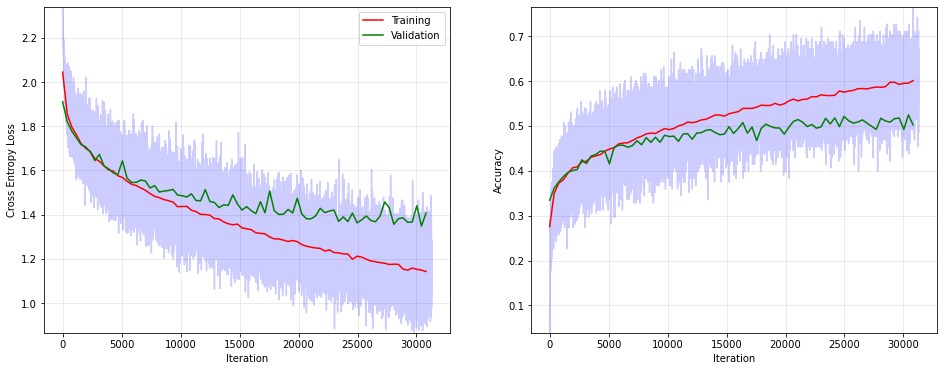

In [160]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

_ = axs[0].plot(range(len(training_losses4)),training_losses4,alpha=0.2,color='b')
_ = axs[0].plot(list(range(0,390*(epochs),390)),[np.array(training_losses4)[(i)*390:(i+1)*390].mean() for i in range(epochs)],color='red',label='Training')
_ = axs[0].plot(list(range(0,390*(epochs),390)),val_losses4,color='green',label='Validation')
_ = axs[0].set_xlabel('Iteration')
_ = axs[0].set_ylabel('Cross Entropy Loss')
_ = axs[0].grid(alpha=0.3)
_ = axs[0].set_ylim(min(training_losses4)-0.0001,max(training_losses4)+0.0001)
_ = axs[0].legend()

_ = axs[1].plot(training_acc4,alpha=0.2,color='b')
_ = axs[1].plot(list(range(0,390*(epochs),390)),[np.array(training_acc4)[(i)*390:(i+1)*390].mean() for i in range(epochs)],color='red',label='Training')
_ = axs[1].plot(list(range(0,390*(epochs),390)),val_acc4,color='green',label='Validation')
_ = axs[1].set_xlabel('Iteration')
_ = axs[1].set_ylabel('Accuracy')
_ = axs[1].grid(alpha=0.3)
_ = axs[1].set_ylim(min(training_acc4)-0.0001,max(training_acc4)+0.0001)

We update the summary as:

| Parameter|Learning rate=0.001 |Learning rate=0.01 |Learning rate=0.1 |Learning rate = 0.01 80 epochs|
|--|--|--|--|--|
|Accuracy Training|29%|53%|42%|60%|
|Accuracy Validation|29%|48%|42%|50%|
|Loss Training|2.04|1.35|1.63|1.17|
|Loss Validation|2.04|1.45|1.64|1.41|

In addition of the previous conclusions, we find that the model with learning rate equal 0.01 had not converged in the first 40 epochs, there is an increase in the accuracy to 60%, we also lower the loss to 1.17, nonetheless we find some overfitting after the epoch 40, the gap between the curves increase as we continue the optimization, to imporove our model we should stop the optimization when the loss function stop decreasing for many epochs, it is the same idea implementend using early stoping in keras. 

At the end we just increase 2% the accuracy in the validation set comparing with the model with 40 epochs, we don't gain predictability by optimizing over more time. 

We can conclude that the best selection of hyperparameters is learning rate = 0.01 and 40 epochs

We also remark that the computational time of this is implementation was very slow, there was not to much time spend in optimzing it, it can be seen in the time for each epoch around 4.4 minutes. The most expensive part of the algorthm was the grads function, the function only uses numpy operations.

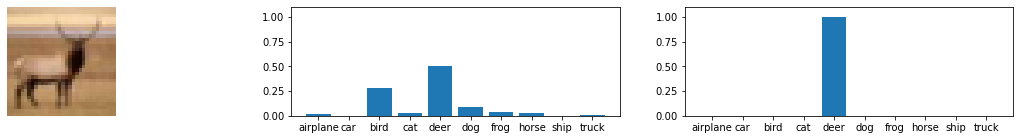

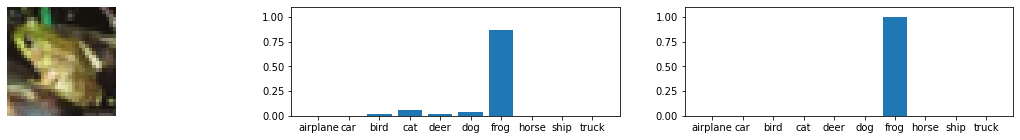

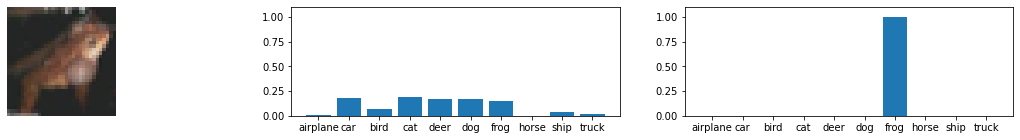

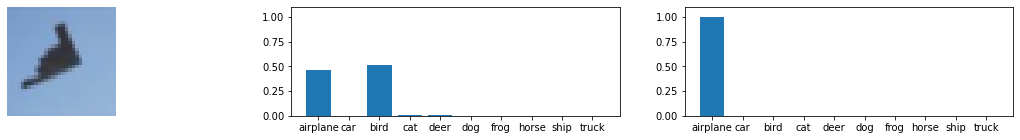

In [161]:
cat = ['airplane','car','bird','cat','deer','dog','frog','horse','ship','truck']
y_hat = mlp(x_val,W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5)
for i in np.random.choice(range(5000),size=4):
    fig, axs = plt.subplots(1,3,figsize=(20,2))
    _ = axs[0].imshow(x_val_total[i])
    _ = axs[0].axis('off')
    _ = axs[1].set_ylim(0,1.1)
    _ = axs[2].set_ylim(0,1.1)
    _ = axs[1].bar(height= y_hat[i], x=cat)
    _ = axs[2].bar(height= y_val[i], x=cat)

Finally we test with some random images selected from the validation dataset, we see some confusion of the model clasifying the second frog. The model also confuses an airplane with a bird in the last example, which makes some sense in the context of the picture

## 1.2 Convolutional neural network
### 1.2.1 Using TensorFlow
The implementation of the convolutional neural network is straight forward using the tools from tensorflow, we can define our model with the <code>Sequential</code> object. The layers of the neural network can be added as elements of a list. 

In [121]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_total, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_total, y_val))

train_dataset = train_dataset.shuffle(353)

train_dataset = train_dataset.batch(128)
val_dataset = val_dataset.batch(89)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [131]:
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3),name='Layer_1'),
    MaxPool2D((2, 2),name='Maximum_Pooling_1'),
    Conv2D(64, (3, 3), activation='relu',name='Layer_2'),
    MaxPool2D((2, 2),name='Maximum_Pooling_2'),
    Conv2D(64, (3, 3), activation='relu',name='Layer_3'),
    Flatten(name='Flatten_layer'),
    Dense(64,activation='relu',name='Fully_Conected_layer'),
    Dense(10,activation='softmax',name='Output')
])

model1.compile(loss='BinaryCrossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'],)
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Conv2D)             (None, 30, 30, 32)        896       
_________________________________________________________________
Maximum_Pooling_1 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
Layer_2 (Conv2D)             (None, 13, 13, 64)        18496     
_________________________________________________________________
Maximum_Pooling_2 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
Layer_3 (Conv2D)             (None, 4, 4, 64)          36928     
_________________________________________________________________
Flatten_layer (Flatten)      (None, 1024)              0         
_________________________________________________________________
Fully_Conected_layer (Dense) (None, 64)               

In total our mode has 122,570 parameters to fit, the optimizer is set to be Stochastic Gradiend Descent with a learning rate of 0.1, the loss function is the binary cross entropy, the batch size is 128, so each epoch consists of 391 iterations.

In [132]:
history1 = model1.fit(train_dataset, epochs=40, batch_size=128,validation_data=val_dataset)

Epoch 1/40
391/391 [==============================] - 28s 72ms/step - loss: 0.3215 - accuracy: 0.1539 - val_loss: 0.3125 - val_accuracy: 0.2081
Epoch 2/40
391/391 [==============================] - 29s 74ms/step - loss: 0.2995 - accuracy: 0.2428 - val_loss: 0.2964 - val_accuracy: 0.2503
Epoch 3/40
391/391 [==============================] - 29s 74ms/step - loss: 0.2839 - accuracy: 0.3001 - val_loss: 0.2733 - val_accuracy: 0.3395
Epoch 4/40
391/391 [==============================] - 29s 74ms/step - loss: 0.2707 - accuracy: 0.3469 - val_loss: 0.2647 - val_accuracy: 0.3572
Epoch 5/40
391/391 [==============================] - 29s 74ms/step - loss: 0.2561 - accuracy: 0.3881 - val_loss: 0.2524 - val_accuracy: 0.3985
Epoch 6/40
391/391 [==============================] - 28s 72ms/step - loss: 0.2444 - accuracy: 0.4190 - val_loss: 0.2426 - val_accuracy: 0.4220
Epoch 7/40
391/391 [==============================] - 29s 73ms/step - loss: 0.2359 - accuracy: 0.4426 - val_loss: 0.2827 - val_accuracy:

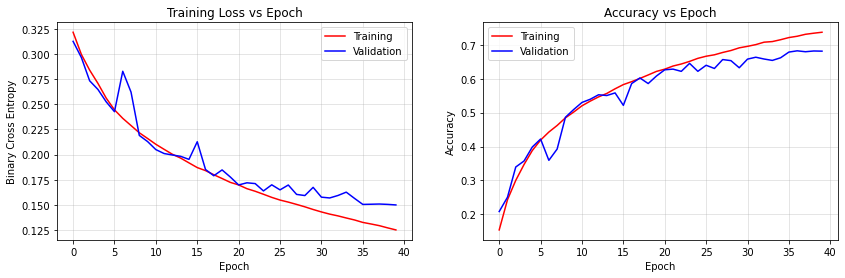

In [160]:
fig,axs = plt.subplots(1,2,figsize=(14,4))

_ = axs[0].plot(history1.history['loss'],color='red',label='Training')
_ = axs[0].plot(history1.history['val_loss'],color='blue',label='Validation')
_ = axs[0].set_xlabel("Epoch")
_ = axs[0].set_ylabel("Binary Cross Entropy")
_ = axs[0].set_title("Training Loss vs Epoch")
_ = axs[0].grid(alpha=0.4)
_ = axs[0].legend()

_ = axs[1].plot(history1.history['accuracy'],color='red',label='Training')
_ = axs[1].plot(history1.history['val_accuracy'],color='blue',label='Validation')
_ = axs[1].set_xlabel("Epoch")
_ = axs[1].set_ylabel("Accuracy")
_ = axs[1].set_title("Accuracy vs Epoch")
_ = axs[1].grid(alpha=0.4)
_ = axs[1].legend()

Both of the plots are as we expected, the parameters are being optimized in the correct direction, the statistics for both training and validation remain very close to each other in the first 25 epochs, but after that poing the curves separate, the loss function for the validation set stos decreasing as was as the accuracy increases at a slower rate. This situation can be categorized as a slight overfitting, altought is not to much. 

### 1.2.2 L2 Regularisation

In [186]:
l2_coeff = 5e-3

model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=regularizers.l2(l2_coeff),name='Layer_1'),
    MaxPool2D((2, 2),name='Maximum_Pooling_1'),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_coeff),name='Layer_2'),
    MaxPool2D((2, 2),name='Maximum_Pooling_2'),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_coeff),name='Layer_3'),
    Flatten(name='Flatten_layer'),
    Dense(64,activation='relu',name='Fully_Conected_layer'),
    Dense(10,activation='softmax',name='Output')
],name='Model_L2_Regularized')

model2.compile(loss='BinaryCrossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'],)
model2.summary()

Model: "Model_L2_Regularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Conv2D)             (None, 30, 30, 32)        896       
_________________________________________________________________
Maximum_Pooling_1 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
Layer_2 (Conv2D)             (None, 13, 13, 64)        18496     
_________________________________________________________________
Maximum_Pooling_2 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
Layer_3 (Conv2D)             (None, 4, 4, 64)          36928     
_________________________________________________________________
Flatten_layer (Flatten)      (None, 1024)              0         
_________________________________________________________________
Fully_Conected_layer (Dense) (None, 64)       

In [187]:
history2 = model2.fit(train_dataset, epochs=40, batch_size=128,validation_data=val_dataset)

Epoch 1/40
391/391 [==============================] - 28s 72ms/step - loss: 0.7135 - accuracy: 0.1615 - val_loss: 0.5798 - val_accuracy: 0.1836
Epoch 2/40
391/391 [==============================] - 26s 67ms/step - loss: 0.4980 - accuracy: 0.1875 - val_loss: 0.4289 - val_accuracy: 0.2181
Epoch 3/40
391/391 [==============================] - 26s 67ms/step - loss: 0.3892 - accuracy: 0.2308 - val_loss: 0.3618 - val_accuracy: 0.2364
Epoch 4/40
391/391 [==============================] - 28s 71ms/step - loss: 0.3409 - accuracy: 0.2534 - val_loss: 0.3254 - val_accuracy: 0.2733
Epoch 5/40
391/391 [==============================] - 26s 65ms/step - loss: 0.3184 - accuracy: 0.2702 - val_loss: 0.3085 - val_accuracy: 0.2898
Epoch 6/40
391/391 [==============================] - 26s 66ms/step - loss: 0.3073 - accuracy: 0.2802 - val_loss: 0.3010 - val_accuracy: 0.2956
Epoch 7/40
391/391 [==============================] - 27s 69ms/step - loss: 0.3004 - accuracy: 0.2912 - val_loss: 0.2981 - val_accuracy:

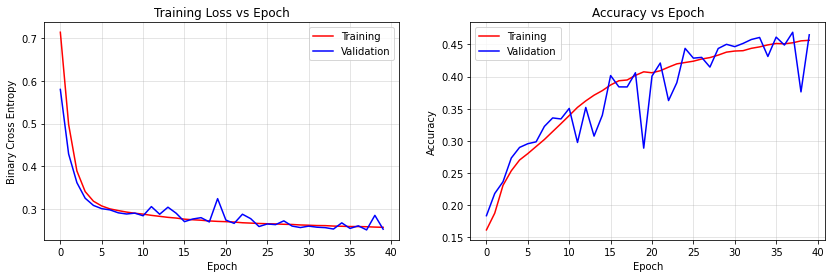

In [188]:
fig,axs = plt.subplots(1,2,figsize=(14,4))

_ = axs[0].plot(history2.history['loss'],color='red',label='Training')
_ = axs[0].plot(history2.history['val_loss'],color='blue',label='Validation')
_ = axs[0].set_xlabel("Epoch")
_ = axs[0].set_ylabel("Binary Cross Entropy")
_ = axs[0].set_title("Training Loss vs Epoch")
_ = axs[0].grid(alpha=0.4)
_ = axs[0].legend()

_ = axs[1].plot(history2.history['accuracy'],color='red',label='Training')
_ = axs[1].plot(history2.history['val_accuracy'],color='blue',label='Validation')
_ = axs[1].set_xlabel("Epoch")
_ = axs[1].set_ylabel("Accuracy")
_ = axs[1].set_title("Accuracy vs Epoch")
_ = axs[1].grid(alpha=0.4)
_ = axs[1].legend()

We get a different result compared to 1.2.1, we don't get a great accuracy after the completition of the algorithm, we only get 46.5% accuracy in the validation set, in terms of the loss we get a very flat curve meaning that we get almost convergence. In this case we don't have signs of overfitting, both curves keep the same trend over the epochs.  

The idea of regularization is to stop the parameters to increase to much, it also encurage the model to become sparse. If we compute the squares of weights of the parameters of both models we find a significant difference, the magnitude decreased in 47% with respect of the model in 1.2.1. The penalization parameter may be to strong it limits the accuracy to grow. 

In [189]:
print(f'Model 1 (reg = 0)   - Sum square weights = {sum([np.sum(w**2) for w in model1.get_weights()]):.3f}')
print(f'Model 2 (reg = 5e-3)- Sum square weights = {sum([np.sum(w**2) for w in model2.get_weights()]):.3f}')

Model 1 (reg = 0)   - Sum square weights = 396.940
Model 2 (reg = 5e-5)- Sum square weights = 207.851


### 1.2.3 Dropout

In this part we only uses a modification of the model from 1.2.2, we add the a dropout between the layers, what this is doing is to remove some edges randomely form the neural net, the advantage of this method is to force the layers to learn independenly from each other, we want them to learn different features from the data. We now implement a convolutional neural network with dropout and two regularizations, we regularize in $L^2$ and $L^1$, we don't use the same parameter for $L^2$ as in 1.2.1, we use a smaller parameter and for the $L^1$ parameter we use something bigger because we deal with $\sum |w_k|$, we don't have the squares so the penalty has to be stronger

In [213]:
l1_coeff = 1e-4
l2_coeff = 1e-5

model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3),kernel_regularizer=regularizers.L1L2(l1_coeff,l2_coeff),name='Layer_1'),
    MaxPool2D((2, 2),name='Maximum_Pooling_1'),
    Dropout(0.5,name='Dropout_1'),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.L1L2(l1_coeff,l2_coeff),name='Layer_2'),
    MaxPool2D((2, 2),name='Maximum_Pooling_2'),
    Dropout(0.5,name='Dropout_2'),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.L1L2(l1_coeff,l2_coeff),name='Layer_3'),
    Dropout(0.5,name='Dropout_3'),
    Flatten(name='Flatten_layer'),
    Dense(64,activation='relu',name='Fully_Conected_layer'),
    Dense(10,activation='softmax',name='Output')
],name='Model_L2_Regularized_Dropout')

model3.compile(loss='BinaryCrossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'],)
model3.summary()

Model: "Model_L2_Regularized_Dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Conv2D)             (None, 30, 30, 32)        896       
_________________________________________________________________
Maximum_Pooling_1 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
Layer_2 (Conv2D)             (None, 13, 13, 64)        18496     
_________________________________________________________________
Maximum_Pooling_2 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
Dropout_2 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
Layer_3 (Conv2D)             (None, 4,

To add the dropout is just to add the function <code>Dropout</code> between the layers, the parameter $p=0.5$ means the probability that one edges is removed from the neural net

In [214]:
history3 = model3.fit(train_dataset, epochs=40, batch_size=128,validation_data=val_dataset)

Epoch 1/40
391/391 [==============================] - 40s 103ms/step - loss: 0.5279 - accuracy: 0.1172 - val_loss: 0.5136 - val_accuracy: 0.1784
Epoch 2/40
391/391 [==============================] - 36s 92ms/step - loss: 0.4962 - accuracy: 0.1803 - val_loss: 0.4819 - val_accuracy: 0.2224
Epoch 3/40
391/391 [==============================] - 35s 88ms/step - loss: 0.4686 - accuracy: 0.2144 - val_loss: 0.4623 - val_accuracy: 0.1929
Epoch 4/40
391/391 [==============================] - 36s 92ms/step - loss: 0.4441 - accuracy: 0.2317 - val_loss: 0.4337 - val_accuracy: 0.2340
Epoch 5/40
391/391 [==============================] - 36s 93ms/step - loss: 0.4214 - accuracy: 0.2452 - val_loss: 0.4122 - val_accuracy: 0.2435
Epoch 6/40
391/391 [==============================] - 38s 96ms/step - loss: 0.3986 - accuracy: 0.2749 - val_loss: 0.3863 - val_accuracy: 0.2891
Epoch 7/40
391/391 [==============================] - 35s 90ms/step - loss: 0.3772 - accuracy: 0.2971 - val_loss: 0.3634 - val_accuracy

In [216]:
print(f'Model 1 (reg2 = 0   , reg1 = 0   )- Sum square weights = {sum([np.sum(w**2) for w in model1.get_weights()]):.3f}')
print(f'Model 2 (reg2 = 5e-3, reg1 = 0   )- Sum square weights = {sum([np.sum(w**2) for w in model2.get_weights()]):.3f}')
print(f'Model 3 (reg2 = 1e-5, reg1 = 1e-4)- Sum square weights = {sum([np.sum(w**2) for w in model3.get_weights()]):.3f}')
print()
print(f'Model 1 (reg2 = 0   , reg1 = 0   )- Sum abs weights = {sum([np.sum(np.abs(w)) for w in model1.get_weights()]):.3f}')
print(f'Model 2 (reg2 = 5e-3, reg1 = 0   )- Sum abs weights = {sum([np.sum(np.abs(w)) for w in model2.get_weights()]):.3f}')
print(f'Model 3 (reg2 = 1e-5, reg1 = 1e-4)- Sum abs weights = {sum([np.sum(np.abs(w)) for w in model3.get_weights()]):.3f}')

Model 1 (reg2 = 0   , reg1 = 0   )- Sum square weights = 396.940
Model 2 (reg2 = 5e-3, reg1 = 0   )- Sum square weights = 207.851
Model 3 (reg2 = 1e-5, reg1 = 1e-4)- Sum square weights = 194.604

Model 1 (reg2 = 0   , reg1 = 0   )- Sum abs weights = 5431.853
Model 2 (reg2 = 5e-3, reg1 = 0   )- Sum abs weights = 3027.494
Model 3 (reg2 = 1e-5, reg1 = 1e-4)- Sum abs weights = 2853.064


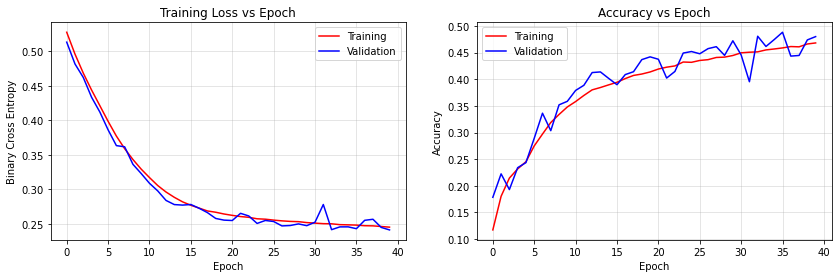

In [217]:
fig,axs = plt.subplots(1,2,figsize=(14,4))

_ = axs[0].plot(history3.history['loss'],color='red',label='Training')
_ = axs[0].plot(history3.history['val_loss'],color='blue',label='Validation')
_ = axs[0].set_xlabel("Epoch")
_ = axs[0].set_ylabel("Binary Cross Entropy")
_ = axs[0].set_title("Training Loss vs Epoch")
_ = axs[0].grid(alpha=0.4)
_ = axs[0].legend()

_ = axs[1].plot(history3.history['accuracy'],color='red',label='Training')
_ = axs[1].plot(history3.history['val_accuracy'],color='blue',label='Validation')
_ = axs[1].set_xlabel("Epoch")
_ = axs[1].set_ylabel("Accuracy")
_ = axs[1].set_title("Accuracy vs Epoch")
_ = axs[1].grid(alpha=0.4)
_ = axs[1].legend()

We don't find a huge difference with respect of model 1.2.1, the effect of the dropout is not ver significant. 

### 1.2.4 Comparison

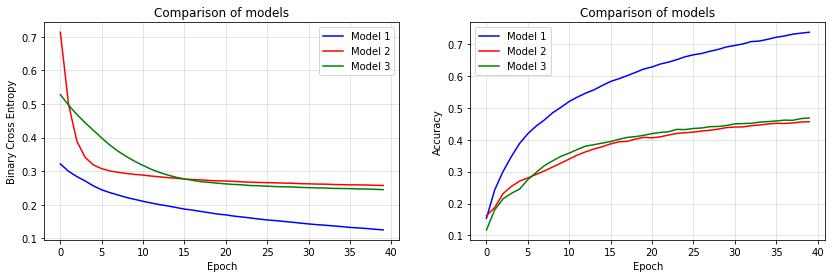

In [218]:
fig,axs = plt.subplots(1,2,figsize=(14,4))

_ = axs[0].plot(history1.history['loss'],label='Model 1',color='blue')
_ = axs[0].plot(history2.history['loss'],label='Model 2',color='red')
_ = axs[0].plot(history3.history['loss'],label='Model 3',color='green')
_ = axs[0].set_xlabel("Epoch")
_ = axs[0].set_ylabel("Binary Cross Entropy")
_ = axs[0].set_title("Comparison of models")
_ = axs[0].grid(alpha=0.4)
_ = axs[0].legend()

_ = axs[1].plot(history1.history['accuracy'],label='Model 1',color='blue')
_ = axs[1].plot(history2.history['accuracy'],label='Model 2',color='red')
_ = axs[1].plot(history3.history['accuracy'],label='Model 3',color='green')
_ = axs[1].set_xlabel("Epoch")
_ = axs[1].set_ylabel("Accuracy")
_ = axs[1].set_title("Comparison of models")
_ = axs[1].grid(alpha=0.4)
_ = axs[1].legend()

|Model| Accuracy Train | Accuracy Validation | Loss Train | Loss Validation | $L^2$ norm| $L^1$ norm|
|--|--|--|--|--|--|--|
|1.2.1|0.7371|0.6813|0.1250|0.1499|396.9|5431.8|
|1.2.2|0.4565|0.4650|0.2573|0.2530|207.8|3027.4|
|1.2.3|0.4682|0.4801|0.2450|0.2410|194.604|2853.0|

We first remark that the 3 models are far from being perfect, all of them has advantages and disadvantages, the first model started overfitting in the first 25 epochs, oneway of improving this model is to use early stopping to get a model that does not overfit to much, doing that we would get a model with around 25 epochs and a accuracy of around 65%. In regard of model 1.2.2 and 1.2.3 we have very similar results the model almost achive a minimun of the loss, the rate of change of the loss and accuracy slows down very quickly, it both models we don't find overfitting, so we could keep optimizing further, and improvement for this model would be to do an exploration of the hyperparameters (learning rate, $L^1$ coefficient, $L^2$ coefficient and dropout probability) and use the best selection. 

# Task 2

## 2.1 Clustering of the feature matrix

In [2]:
X = np.genfromtxt('Data/feature_matrix_karate_club.csv',delimiter=',')[1:,1:]
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,...,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.092756,-0.045116,-0.078589,0.022380,-0.046291,0.101231,-0.006378,-0.007856,-0.013739,0.093518,...,-0.072664,0.037633,0.067134,-0.074020,0.029579,-0.063639,-0.018444,0.040850,-0.034742,0.056527
std,0.075746,0.103148,0.063907,0.078538,0.074103,0.119355,0.115739,0.106600,0.115659,0.140047,...,0.063397,0.082987,0.095994,0.097236,0.087088,0.152729,0.092477,0.069262,0.098226,0.133509
min,-0.113510,-0.262451,-0.161568,-0.165533,-0.230700,-0.117825,-0.206979,-0.279716,-0.210795,-0.302302,...,-0.189510,-0.122496,-0.125950,-0.307295,-0.153391,-0.366537,-0.175491,-0.127332,-0.218923,-0.251836
25%,0.040423,-0.127374,-0.123831,-0.016255,-0.065949,0.017477,-0.072496,-0.070706,-0.087543,0.055788,...,-0.111590,-0.024310,0.019176,-0.107064,-0.041222,-0.179288,-0.080675,0.007624,-0.103564,-0.021840
50%,0.092534,-0.047921,-0.087450,0.023166,-0.048777,0.086824,-0.019321,0.022096,-0.037313,0.123904,...,-0.089995,0.032920,0.072195,-0.055894,0.015174,-0.043548,-0.033683,0.027831,-0.053286,0.078599
75%,0.146899,0.029343,-0.045687,0.067570,-0.007922,0.188491,0.056004,0.070105,0.035076,0.193471,...,-0.039412,0.086222,0.094915,-0.002427,0.090864,0.062157,0.045063,0.088841,0.040203,0.154420
max,0.212280,0.145507,0.107496,0.203272,0.155897,0.379257,0.231879,0.121299,0.292380,0.341475,...,0.098073,0.208166,0.270242,0.068121,0.241319,0.172031,0.161801,0.176730,0.209365,0.267839


We have 100 variables and 34 instances. We compute the correlation to visualize any structure over the variables

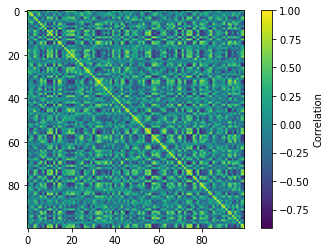

In [3]:
_ = plt.imshow(pd.DataFrame(X).corr(),cmap='viridis')
_ = plt.colorbar(label='Correlation')

We can see some very correlated variables outside of the diagonal

We recall the pairwise distance function

In [4]:
def pairwise_distances(points):
    '''
    Args:
        points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
    Returns:
        A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
    '''
    N, D = points.shape
    distance = np.empty((N, N))
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            d = np.linalg.norm(points[i, :] - points[j, :])
            distance[i, j] = d
            distance[j, i] = d

    return distance

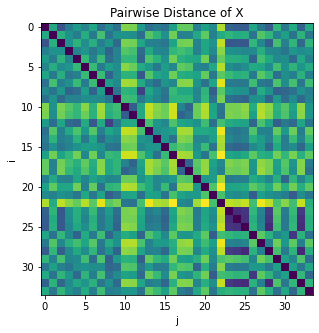

In [5]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
cs = axs.imshow(pairwise_distances(X))
_ = axs.set_ylabel('i')
_ = axs.set_xlabel('j')
_ = axs.set_title('Pairwise Distance of X')

The structure is not very clear from the pairwise distance of X

## 2.1.1 K Means
One important characteristic for our k-means clustering is that it in fact divides the dataset in k clusters, we modify the algorithm from the coding tasks to achieve it. If a class end being empty we move the point that is clossest to the centroid of the empty class to the class, in this way we ensure that there are not empty classes.

To analyze the clusters we define the within distance function

In [6]:
def K_means_cluster(X,k,max_iter,random_seed=True):

    n_samples, n_features = X.shape

    # labels: assign every sample to a cluster at random
    if random_seed: np.random.seed(123)
    labels = np.random.permutation(np.array(list(range(k+1))*100)[:n_samples])
    centroids = np.zeros((k, n_features))

    for c in range(k):
        centroids[c] = np.mean(X[labels==c], axis=0)
        
    new_labels = np.zeros(len(X))

    for i in range(max_iter):
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)
        
        #We ensure that every cluster is nonempy with the following loop 
        changed = []
        for c in range(k):
            if sum(new_labels == c) == 0:
                iindex = np.argsort(np.linalg.norm(X - centroids[c], axis=1),axis=0) #We assign the closest point to the empty cluster
                
                for l in iindex:
                    if l in changed:#We ensure we only change once the labels
                        pass
                    else:
                        changed.append(l)
                        new_labels[l] = c
                        break
        
        if (labels==new_labels).all() and k == len(np.unique(new_labels)):
            labels = new_labels
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            labels = new_labels  
            for c in range(k):
                centroids[c] = np.mean(X[labels==c], axis=0)
                
    return(labels)
def within_distance(X,labels):
    wd = 0 
    for l in np.unique(labels):
        cl = X[labels == l]
        wd += (1/(2*cl.shape[0]) )* np.sum(pairwise_distances(cl)**2)
    return(wd)

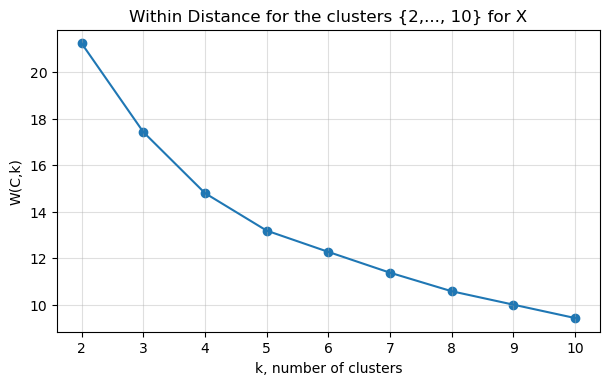

In [7]:
n_sim = 100

within_distances = np.zeros((9,n_sim))

for r in range(n_sim):
    for k in range(2,11):
        labels = K_means_cluster(X,k,100,random_seed=False)
        within_distances[k-2,r] = within_distance(X,labels)
        
fig, axs = plt.subplots(1,1,figsize=(7,4),dpi=100)
_ = axs.set_ylabel("W(C,k)")
_ = axs.set_xlabel("k, number of clusters")
_ = axs.set_title("Within Distance for the clusters {2,..., 10} for X")
_ = axs.plot(range(2,11), np.mean(within_distances,axis=1))
_ = axs.scatter(range(2,11), np.mean(within_distances,axis=1))
_ = axs.grid(alpha=0.4)

In this plot what we look for is the elbow, in this case is not completely clear where it is, our candidates for the selection would be 4, 5 or 6. The selection of the number of clusters could not be purely selected from this curve but if we had to choose only from the within distance will have to be $k=5$

### 2.1.2 Calinski Harabasz score

The Calinski-Harabasz score is an index to measure the dispersion of the clustes, it is defined as the ratio between the within dispersion the clusters and the total dispersion of the data set. We define $n$ be the total number of observations of $X$, $k$ the number of clusters and deonte the $l$ cluster as $c_l$ and the mean point of each cluster a $C_l$ then the Calinski-Harabasz score is defined as 

$$\text{CH}(k) = \frac{\text{tr}\left[\sum_{l=1}^{k}n_l (C_N-C_l)(C_N-C_l)^{\top} \right]}{\text{tr}\left[\sum_{l=1}^{k}\sum_{x\in c_l} (x-C_l)(x-C_l)^{\top}\right]}\times \frac{n-k}{k-1} $$
Where $C_N$ denote the mean point of the complete dataset. We consider that a clustering is good when we have a high index  $\text{CH}$

The implementation is a transcription of the formula to python and numpy

In [8]:
def Calinski_Harabasz(X,labels):
    n,m = X.shape
    k = len(np.unique(labels))
    Cn = np.mean(X,axis=0).reshape(m,1)
    B = np.zeros((m,m))
    W = np.zeros((m,m))
    
    for l in range(k):
        Cl= np.mean(X[labels == l,...],axis=0).reshape(m,1)
        nl = len(X[labels == l])
        B += nl * ((Cn - Cl) @ (Cn - Cl).T)
        for x in X[labels == l]:
            W += (x.reshape(m,1)-Cl) @ (x.reshape(m,1)-Cl).T

    CH = (np.trace(B)/np.trace(W)) * (n-k)/ (k-1)

    return(CH)

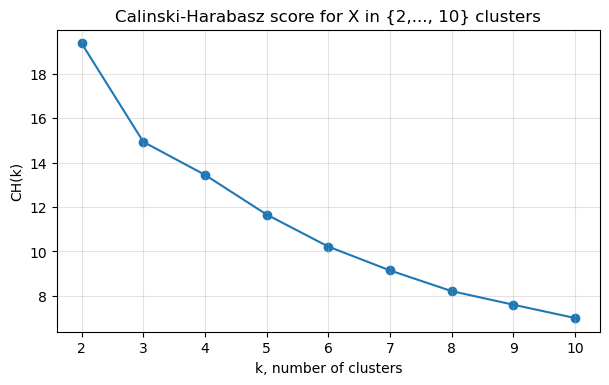

In [9]:
CHs = np.zeros((9,n_sim))
for r in range(n_sim):
    for k in range(2,11):
        labels = K_means_cluster(X,k,100,random_seed=False)
        CHs[k-2,r] = Calinski_Harabasz(X,labels)
    

fig, axs = plt.subplots(1,1,figsize=(7,4),dpi=100)

_ = axs.set_title("Calinski-Harabasz score for X in {2,..., 10} clusters")    
_ = axs.set_ylabel("CH(k)")
_ = axs.set_xlabel("k, number of clusters")
_ = axs.plot(range(2,11), np.mean(CHs,axis=1))
_ = axs.scatter(range(2,11),  np.mean(CHs,axis=1))
_ = axs.grid(alpha=0.35)

In this case we want to have the maximum value for the CH index, so the selection for best clustering is 2 using only this criterion

### 2.1.3 Robustness of the selection of k

To measure the robustness of the selection of the optimal number of clusters we consider the within distance and the CH index as statistics, if we are going to base our selection on those statistics we would need the variability of our selection to be small. We consider the 100 realizations of the clusters and compute the variance for each of the values for k. We would like to find a small variance in our selection, if the variance is big in the selection we take the risk of not getting the best selection of k

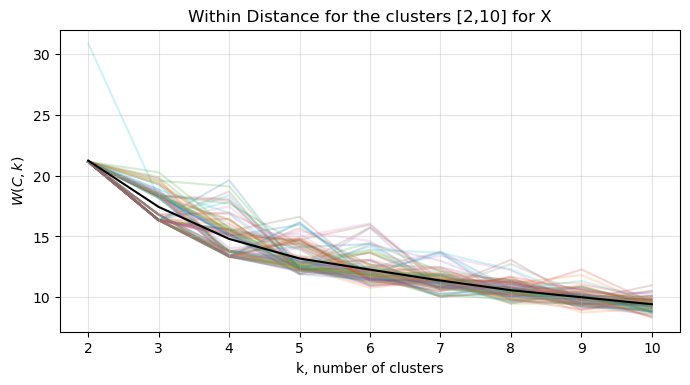

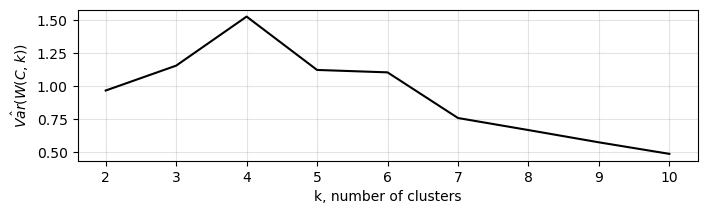

In [10]:
fig, axs = plt.subplots(1,1,figsize=(8,4),dpi=100)
_ = axs.set_ylabel("$W(C,k)$")
_ = axs.set_xlabel("k, number of clusters")
_ = axs.set_title("Within Distance for the clusters [2,10] for X")

_ = axs.plot(range(2,11), within_distances,zorder = 1,alpha=0.2)
_ = axs.plot(range(2,11), np.mean(within_distances,axis=1),zorder=2,color='k')
_ = axs.grid(alpha=0.35)

fig, axs = plt.subplots(1,1,figsize=(8,2),dpi=100)
_ = axs.set_ylabel("$\hat{Var}(W(C,k))$")
_ = axs.set_xlabel("k, number of clusters")
_ = axs.plot(range(2,11), np.std(within_distances,axis=1),zorder=2,color='k')
_ = axs.grid(alpha=0.35)


For the within distance we find the bigger variance in the selection of the parmeter $k=4$, we also have a big variance in the parameter $k=5$. 

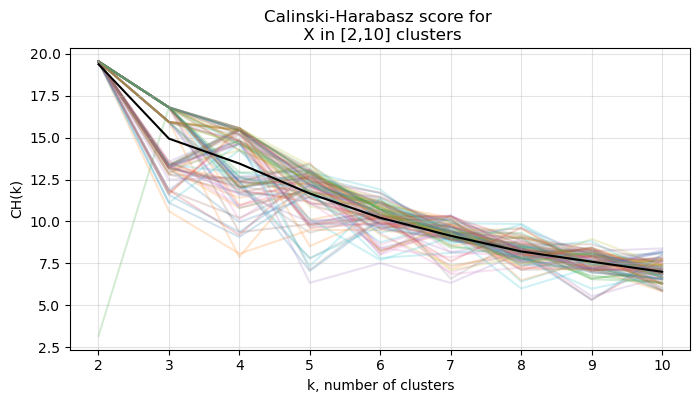

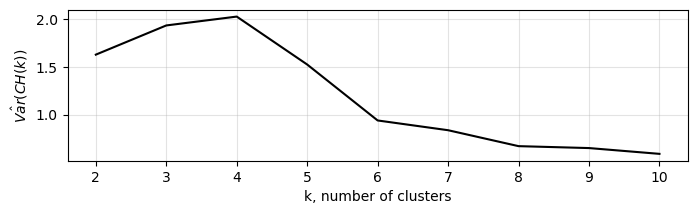

In [11]:
fig, axs = plt.subplots(1,1,figsize=(8,4),dpi=100)

_ = axs.set_title("Calinski-Harabasz score for \n X in [2,10] clusters")    
_ = axs.set_ylabel("CH(k)")
_ = axs.set_xlabel("k, number of clusters")
_ = axs.plot(range(2,11),CHs,alpha=0.2,zorder=1)
_ = axs.plot(range(2,11), np.mean(CHs,axis=1),zorder=2,color='k')
_ = axs.grid(alpha=0.35)

fig, axs = plt.subplots(1,1,figsize=(8,2),dpi=100)

_ = axs.set_ylabel("$\hat{Var}(CH(k))$")
_ = axs.set_xlabel("k, number of clusters")
_ = axs.plot(range(2,11), np.std(CHs,axis=1),zorder=2,color='k')
_ = axs.grid(alpha=0.35)

In cluster size $k=2$ the variance is 0 for the CH index. The selection of $k$ would be robust. In contrast to the selection of $k=5$ using the curve from the within distance select $k=2$ would be more robust, for any selection of initial clusters the CH index is maximal

## 2.2 Dimensionality Reduction

### 2.2.1 PCA d = 1, 2, 3

The principal idea of PCA is to compute a lower dimensional aproximation of the data minimizing the information lost in the process. It is posible to do that by computing the spectral decomposition of the the correlation matrix $A^{\top}A$, then we select the $k$ leading eigenvalues and project the data into the space spaned by those eigenvectors, this algorithm ensures that we the information lost is minimal, that can be analyzed from the statistical point of view, each eigenvalue of the matrix $A^{\top}A$ is a fraction of the variance, the total variance of the information is the sum of all the eigenvalues. To know how much information are we mainting reducing the dimension we can compute the proportion of variance of the fist $d$ eigenvalues with respect of the total variance.

In [12]:
def pca_function(X,k):

    # create covariance matrix S
    Xs = X - X.mean(axis=0)
    C = 1.0/(len(Xs)-1) * np.dot(Xs.T, Xs)


    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = Xs.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

The algorithm is quite simple, substract the mean of the observations, compute the correlation matrix and compute the $k$ leading eigenvalues, the proyection is the dot product of the eigenvectors with the original data. 

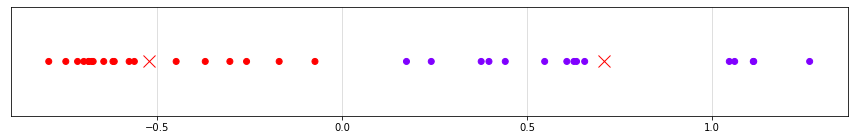

In [13]:
labels = K_means_cluster(X,2,100)

X_pca,eigenvectors,eigenvalues = pca_function(X,1)
plt.figure(figsize=(15,2))
plt.yticks([])
plt.scatter(X_pca[:,0],np.zeros(34),c=labels,cmap='rainbow')

plt.plot(np.mean(X[labels==0],axis=0).dot(eigenvectors),[0],marker='x',ms=12,color='red')
plt.plot(np.mean(X[labels==1],axis=0).dot(eigenvectors),[0],marker='x',ms=12,color='red')

plt.grid(alpha=0.5)

In one dimension we can see very clear the separation of the clusters using $k=2$, we also plot the centralities of the clusters in red.

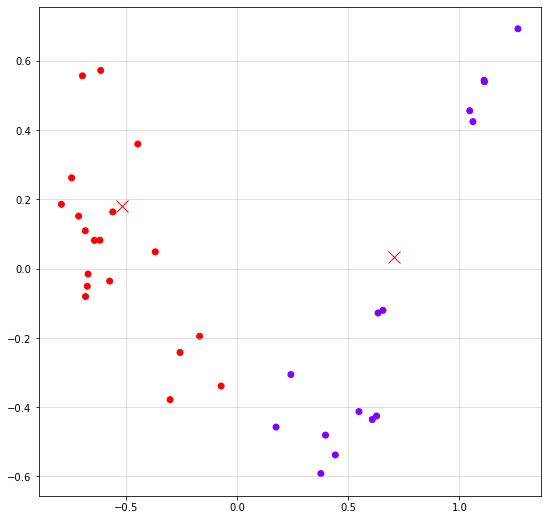

In [14]:
X_pca,eigenvectors,eigenvalues = pca_function(X,2)
plt.figure(figsize=(9,9))
plt.scatter(X_pca[:,0],X_pca[:,1],c=labels,cmap='rainbow')

cen1 = np.mean(X[labels==0],axis=0).dot(eigenvectors)
cen2 = np.mean(X[labels==1],axis=0).dot(eigenvectors)

plt.plot(cen1[0],cen1[1],marker='x',ms=12,color='red')
plt.plot(cen2[0],cen2[1],marker='x',ms=12,color='red')

plt.grid(alpha=0.5)

Again using $k=2$ the separation is clear

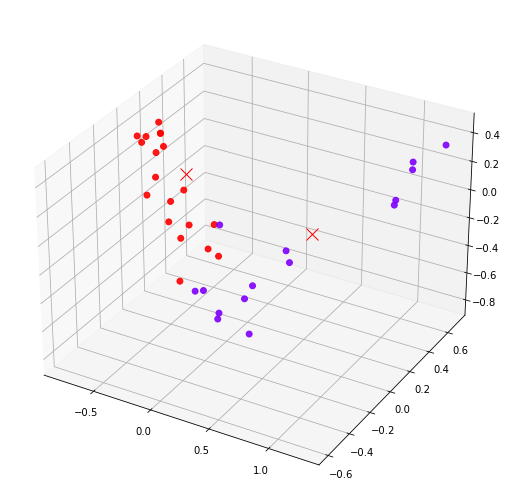

In [15]:
X_pca,eigenvectors,eigenvalues = pca_function(X,3)
fig = plt.figure(figsize=(9,9))
_ = ax = fig.add_subplot(111, projection='3d')
_ = ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],s=35,c=labels,alpha=0.9,cmap='rainbow')

cen1 = np.mean(X[labels==0],axis=0).dot(eigenvectors)
cen2 = np.mean(X[labels==1],axis=0).dot(eigenvectors)

_ = ax.plot(cen1[0],cen1[1],cen1[2],marker='x',ms=12,color='red')
_ = ax.plot(cen2[0],cen2[1],cen2[2],marker='x',ms=12,color='red')

As expected in 3d we still can see the split between the two clusters. For all of the selections of dimensions the cluster were very clearly separable in the projection. 

### 2.2.2 Variance explained

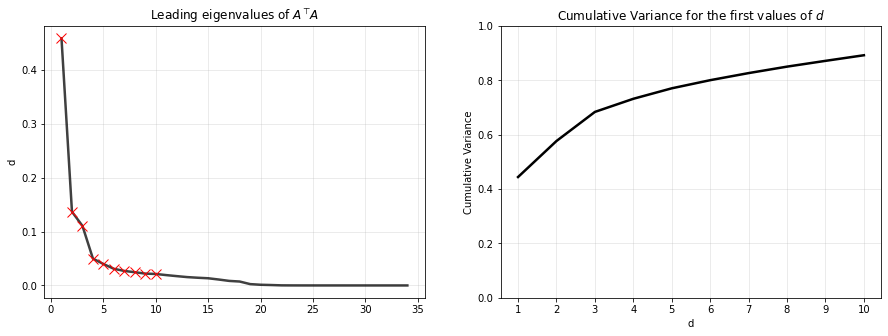

In [18]:
X_pca,tota_vectors,tota_values = pca_function(X,34)
total_variance = np.sum(tota_values) 
cum_variance = []
for d in range(1,11):
    X_pca,eigenvectors,eigenvalues = pca_function(X,d)
    cum_variance.append(np.sum(eigenvalues) / total_variance)

fig,axs = plt.subplots(1,2,figsize=(15,5))    
    
_ = axs[0].grid(alpha=0.3)
_ = axs[0].plot(range(1,35),tota_values,lw=2.5,alpha=0.75,color='k')
_ = axs[0].plot(range(1,11),tota_values[:10],'x',color='r',ms=10)
_ = axs[0].set_ylabel('Eigenvalues')
_ = axs[0].set_title('Leading eigenvalues of $A^{\\top}A$')
_ = axs[0].set_ylabel('d')

_ = axs[1].grid(alpha=0.3)
_ = axs[1].plot(range(1,11),cum_variance,lw=2.5,color='k')
_ = axs[1].set_xticks(range(1,11))
_ = axs[1].set_ylim((0,1))
_ = axs[1].set_yticks(np.linspace(0,1,6),[f'{x*100:.0f}%' for x in np.linspace(0,1,6)])
_ = axs[1].set_title('Cumulative Variance for the first values of $d$')
_ = axs[1].set_ylabel('Cumulative Variance')
_ = axs[1].set_xlabel('d')

We plot the magnitude of the first eigenvalues of $A^{\top}A$ in the left, we can see that the first eigenvector is considerably bigger than all of the others, the magnitudes decreases very fast, that means that the data can be expresed in a low dimension without lossing to much information. In the first 10 eigenvalues we go from 36 to 2.8 of variance. In the plot in the right we acumulate the total variance up to each dimension, we can see that using the first eigenvector we already have 35% of the complete variance of the data, going up to $d=10$ we get 86.3% percent of the total variance. This fast increase in the cummulative variance explaing why we could see the split in the clusters, the clusters were done with the complete 100 dimensions but the separation of the instances can be seen from the 3 lower dimensions. 

## 2.3 Graph-based analysis

### 2.3.1 Centralities

In [19]:
A = np.genfromtxt('Data/karate_club_graph.csv',delimiter=',')[1:,1:]
n = len(A)

In [20]:
def PageRank(A,alpha = 0.85,num_iterations=120):
    """
    Computes the Pagerank for a graph with adjacency 
    matrix A, the algorithm iterates to get stationary 
    distribution
    
    :input A: nxn numpy array Adjacency matrix
    :input alpha: a float probability of scape from neighbours
    :input num_iterations: an integer
    
    :return v: a nx1 numpy array
    """
    n = A.shape[1]
    np.random.seed(1)
    v = np.random.rand(n, 1)
    d = A@np.ones(n)
    D_1 = np.diag(1/d)
    A_hat = alpha * (A @ D_1) @v + (1 - alpha) / n
    for i in range(num_iterations):
        v = alpha * (A @ D_1) @v + (1 - alpha) / n
    return v
def degree_centrality(A):
    """
    Computes the degree centrality for a graph with
    adjacency matrix A using the degrees of the 
    graph
    
    :input A: nxn numpy array Adjacency matrix
    
    :return v: a nx1 numpy array
    """
    n = A.shape[0]
    d = (A@np.ones(n)).reshape(n,1)
    E = (1/2) * np.sum(d)
    return(d / (2*E))
def eigen_centrality(A):
    """
    Computes the eigenvector crentrality for a graph with
    adjacency matrix A using the spectral decomposition of 
    the matrix A
    
    :input A: nxn numpy array Adjacency matrix
    
    :return v: a nx1 numpy array
    """
    n = A.shape[0]
    l,v = eigh(A,eigvals=(n-1,n-1))
    return(v/np.sum(v))

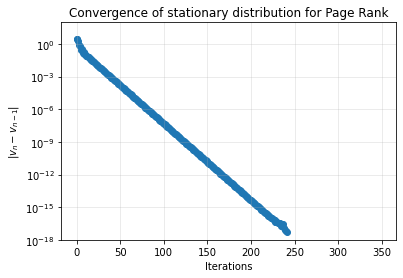

In [21]:
v2 = 0 
err = []
for i in range(350):
    v1 = PageRank(A,num_iterations=i)
    err.append(np.linalg.norm(v1 - v2))
    v2 = v1
_ = plt.scatter(range(350),err)
_ = plt.ylabel('$|v_{n} - v_{n-1}|$')
_ = plt.xlabel('Iterations')
_ = plt.title('Convergence of stationary distribution for Page Rank')
_ = plt.yscale('log')
_ = plt.grid(alpha=0.3)
_ = plt.ylim(1e-18,1e2)

We first verifiy the convergence of the PageRank algorithm, it convergence after 250 iterations.

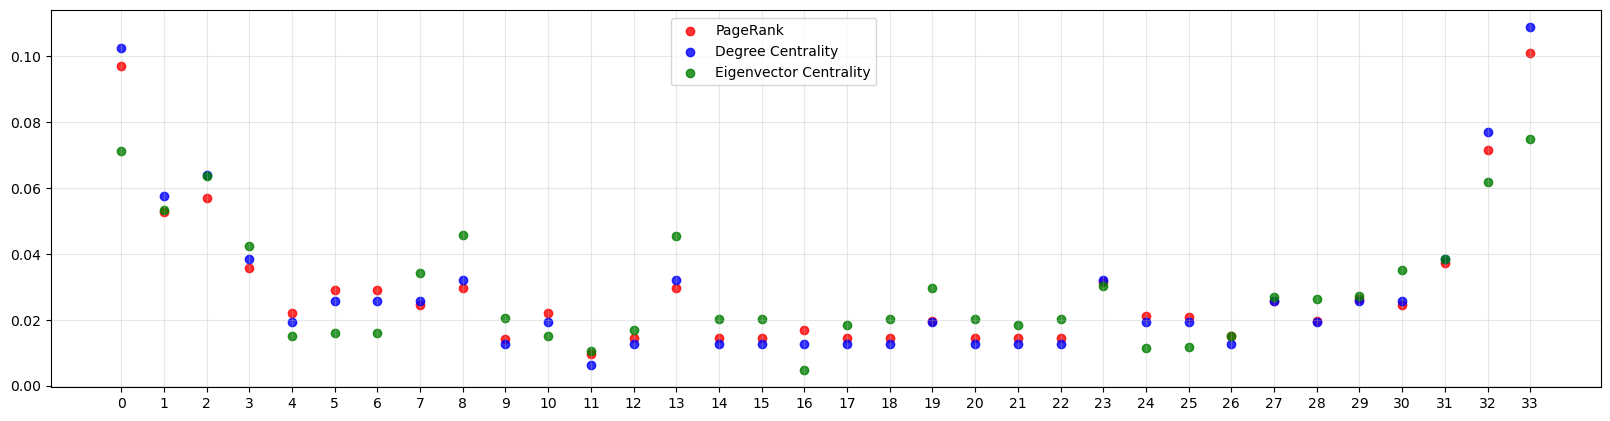

In [22]:
c1 = PageRank(A,num_iterations=250)
c2 = degree_centrality(A)
c3 = eigen_centrality(A)

_ = plt.figure(figsize=(20,5),dpi=100)
_ = plt.scatter(range(34),c1,alpha=0.8,label='PageRank',color='r')
_ = plt.scatter(range(34),c2,alpha=0.8,label='Degree Centrality',color='b')
_ = plt.scatter(range(34),c3,alpha=0.8,label='Eigenvector Centrality',color='g')
_ = plt.grid(alpha=0.3)
_ = plt.xticks(range(34))
_ = plt.legend(loc=(0.4,0.8))

From the values of centralities itself we find them very similar, they for sure are correlated, that is expected because we are measuring the same. 

,PageRank,Degree Centrality,Eigenvector Centrality
PageRank,1.000000,0.997904,0.891929
Degree Centrality,0.997904,1.000000,0.917255
Eigenvector Centrality,0.891929,0.917255,1.000000


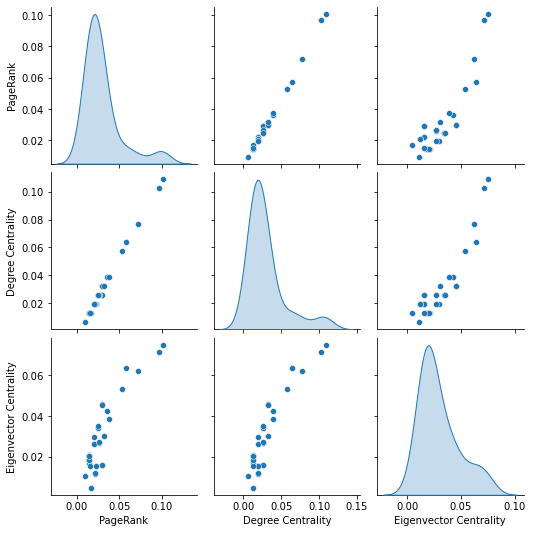

In [23]:
Centralities = pd.DataFrame(np.concatenate([c1,c2,c3],axis=1),columns=['PageRank','Degree Centrality','Eigenvector Centrality'])
display(Centralities.corr())
ax = sns.pairplot(Centralities,diag_kind='kde')

PageRang and Degree centrality are the most similar, and Eigenvector centrality and PageRank are the most different ones. We now focus in the raking that this measures produce

In [24]:
Centralities['PageRank Rank'] = Centralities['PageRank'].rank(ascending=False).astype('int')
Centralities['Degree Centrality Rank'] = Centralities['Degree Centrality'].rank(ascending=False).astype('int')
Centralities['Eigenvector Centrality Rank'] =Centralities['Eigenvector Centrality'].rank(ascending=False).astype('int')
display(Centralities.sort_values('PageRank',ascending=False))

,PageRank,Degree Centrality,Eigenvector Centrality,PageRank Rank,Degree Centrality Rank,Eigenvector Centrality Rank
33,0.100919,0.108974,0.075003,1,1,1
0,0.096997,0.102564,0.071413,2,2,2
32,0.071693,0.076923,0.062002,3,3,4
2,0.057079,0.064103,0.063719,4,4,3
1,0.052877,0.057692,0.053427,5,5,5
31,0.037158,0.038462,0.038376,6,6,9
3,0.035860,0.038462,0.042423,7,6,8
23,0.031523,0.032051,0.030156,8,9,12
8,0.029766,0.032051,0.045682,9,9,6
13,0.029536,0.032051,0.045495,10,9,7


We can see that PageRank and Degree Centrality agrees with most of the ranks, more importantly in the top and the bottom, nonetheless the ranks given by the eigenvector centrality are different, the biggest diference can is in the bottom correlated nodes 

|Top|PageRank|Degree Centrality |	Eigenvector Centrality |
|--|--|--|--|
|1|33|33|33|
|2|0|0|0|
|3|32|32|2|
|4|2|2|32|
|5|1|1|1|

### 2.3.2 Community detection

The computation of the community using the Clauset-Newman-Moore greedy modularity maximisation algorithm is done easily by using the method <code>greedy_modularity_communities</code>, the input is simple the graph object from NetworkX. The output is lost of the sets for each of the communities detected, we can transform it to an array.

In [25]:
G = nx.Graph(A)
community = greedy_modularity_communities(G)
k = len(community)
c_array = sum([np.array([x in community[i] for x in range(n)])*i for i in range(k)])
display(c_array)

array([2, 1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

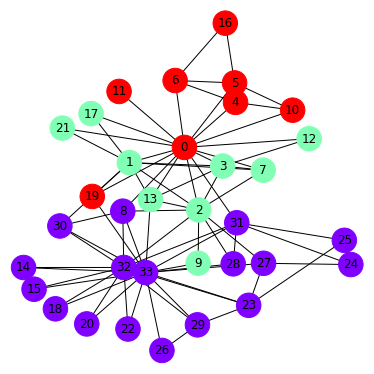

In [26]:
_ = plt.figure(figsize=(5,5))
_ = nx.draw(G,node_color=c_array,labels={node:node for node in G.nodes()},node_size=600,cmap='rainbow',pos=nx.kamada_kawai_layout(G))

From the draw the $k^* = 3$  communities are connected as expected and forms clusters of nodes

In [27]:
top_c2 = np.flip(np.argsort(c2.T).reshape(n))[:8]
top_c1 = np.flip(np.argsort(c1.T).reshape(n))[:8]

In [28]:
print("Top degree centrality   = ",top_c2, "Community = ",1+c_array[top_c2] )
print("Top PageRank centrality = ",top_c2, "Community = ",1+c_array[top_c2] )

Top degree centrality   =  [33  0 32  2  1 31  3 23] Community =  [1 3 1 2 2 1 2 1]
Top PageRank centrality =  [33  0 32  2  1 31  3 23] Community =  [1 3 1 2 2 1 2 1]


We have the same distribution over first 8 nodes with highest centrality, in community 1 we have 4 of the top 8, in community 2 we have 3 and 2 in the third community, in a sense we can think that community 1 is the most important because it has most of the most connected nodes of the graph 

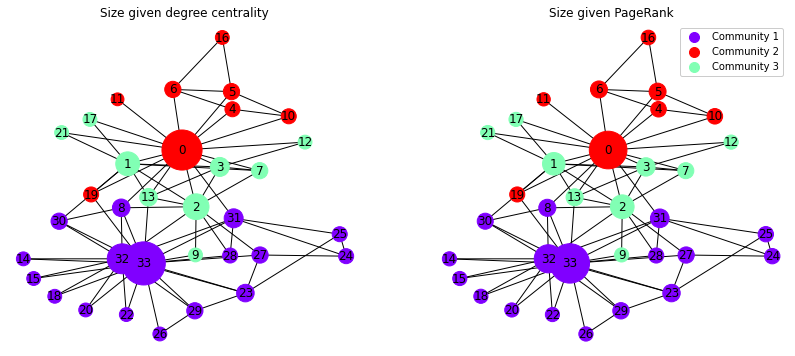

In [29]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
_ = axs[0].set_title("Size given degree centrality")
_ = nx.draw(G,node_color=c_array,labels={node:node for node in G.nodes()},node_size=140*(c2+1)**25,cmap='rainbow',ax=axs[0],pos=nx.kamada_kawai_layout(G))
_ = axs[1].set_title("Size given PageRank")
_ = nx.draw(G,node_color=c_array,labels={node:node for node in G.nodes()},node_size=140*(c1+1)**25,cmap='rainbow',ax=axs[1],pos=nx.kamada_kawai_layout(G))
legend_elements = [plt.scatter([0.55], [0.8], color=plt.cm.rainbow(0.001), label='Community 1',s=100),
                   plt.scatter([0.55], [0.8], color=plt.cm.rainbow(0.99), label='Community 2',s=100),
                   plt.scatter([0.55], [0.8], color=plt.cm.rainbow(0.5), label='Community 3',s=100)]
_ = plt.legend(handles=legend_elements,loc='upper right',framealpha=1)

Ploting the centrality and the communities at the same time we see the same, commuity 1 contains more of the highly central nodes, meanwhile community 3 does not have a very central node.

### 2.3.3 Comparison of clusters (ARI)

The Adjusted Rand index is measure of similarity between different clusters, it compares the clusters themselfs it does not use the underlying data from which the clusters were derived. It is cumputed using the formula 

$$\text{ARI} = \frac{\sum_{ij}{n_{ij} \choose 2} - \left[\sum_{i}{a_{i} \choose 2}\sum_{j}{b_{j} \choose 2} \right] / {n \choose 2}}{\frac{1}{2} \left[\sum_{i}{a_{i} \choose 2}+\sum_{j}{b_{j} \choose 2} \right] -  \left[\sum_{i}{a_{i} \choose 2}\sum_{j}{b_{j} \choose 2} \right]} $$

Where $n_ij$ is the number of elements in the intersection of the ith cluster given by the first partition and the jth cluster given by the second partition. $a_i$ is the number of elements in the ith cluster of the first partition and $b_j$ the number of elements in the jth cluster of the second partition.

If we compute this index for the same parition we have $\text{ARI} =1$, the index is close to 1 when the 2 partitions are very similar, and close to 0 when they are different.

The implementation is simply a translation of the formula to python language

In [30]:
from math import comb
def ARI(X,Y):
    n = len(X)
    r = len(np.unique(X))
    s = len(np.unique(Y))
    N = np.zeros((r,s))
    for x in np.unique(X):
        for y in np.unique(Y):
            N[x,y] = sum((X == x)*(Y==y))
    a = np.sum(N,axis=1)
    b = np.sum(N,axis=0)
    
    s1 = sum(comb(int(N[i,j]),2) for i in range(r) for j in range(s))
    s2 = sum(comb(int(a[i]),2) for i in range(r))
    s3 = sum(comb(int(b[j]),2) for j in range(s))
    s4 = comb(n,2)
    
    ARI = (s1 - (s2*s3)/s4) / (0.5* (s2 + s3) - (s2*s3)/s4) 

    return(ARI)

K Means partition              =  [1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0]
Clauset-Newman-Moore community =  [2 1 1 1 2 2 2 1 0 1 2 2 1 1 0 0 2 1 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0]

ARI = -0.03149


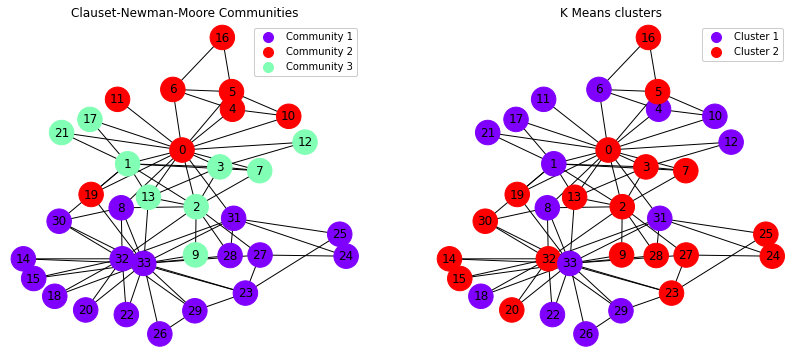

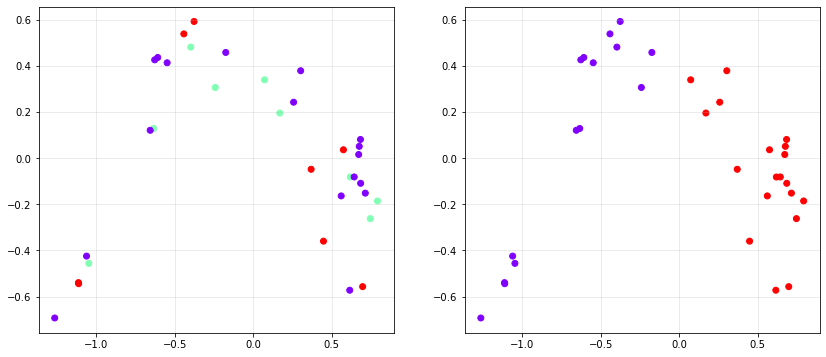

In [31]:
labels = K_means_cluster(X,2,1000)
print("K Means partition              = ",labels)
print("Clauset-Newman-Moore community = ",c_array)
print()
print(f"ARI = {ARI(labels,c_array):.5f}" )

fig,axs = plt.subplots(1,2,figsize=(14,6))
_ = axs[0].set_title("Clauset-Newman-Moore Communities")
_ = nx.draw(G,node_color=c_array,labels={node:node for node in G.nodes()},node_size=600,cmap='rainbow',ax=axs[0],pos=nx.kamada_kawai_layout(G))
_ = axs[1].set_title("K Means clusters")
_ = nx.draw(G,node_color=labels,labels={node:node for node in G.nodes()},node_size=600,cmap='rainbow',ax=axs[1],pos=nx.kamada_kawai_layout(G))
legend_elements = [plt.scatter([0.55], [0.9], color=plt.cm.rainbow(0.001), label='Community 1',s=100),
                   plt.scatter([0.55], [0.9], color=plt.cm.rainbow(0.99), label='Community 2',s=100),
                   plt.scatter([0.55], [0.9], color=plt.cm.rainbow(0.5), label='Community 3',s=100)]
_ = axs[0].legend(handles=legend_elements,loc='upper right',framealpha=1)
legend_elements = [plt.scatter([0.55], [0.9], color=plt.cm.rainbow(0.001), label='Cluster 1',s=100),
                   plt.scatter([0.55], [0.9], color=plt.cm.rainbow(0.99), label='Cluster 2',s=100)]
_ = axs[1].legend(handles=legend_elements,loc='upper right',framealpha=1)

fig,axs = plt.subplots(1,2,figsize=(14,6))
X_pca,eigenvectors,eigenvalues = pca_function(X,2)
axs[0].scatter(X_pca[:,0],X_pca[:,1],c=c_array,cmap='rainbow')
axs[0].grid(alpha=0.3)
axs[1].scatter(X_pca[:,0],X_pca[:,1],c=labels,cmap='rainbow')
axs[1].grid(alpha=0.3)

We have an index of  -0.03149 which is close to 0, that means that the partitions are very different, if we compare the 2 perspective that were used to compute the partitions (data analysis and graph) we find a very different distribution of the of the partitions. The partition got from the Clauset-Newman-Moore community detection is very clear in the graph meanwhile the k means partition is very mixed. In the 2 dimension representation of the data we find that the Clauset-Newman-Moore community detection does not show a particularly interesting distribution. 

__The complete comparison of the communities and the ground truth can be found in section 3.2.2__

# Task 3

## 3.1 Louvain algorithm for community detection

The Louvain algorithm is a method for community detection, the algorithm maximizes the modularity, the modularity  is a property of a network and a specific proposed division of that network into communities. It measures when the division is a good, in the sense that there are many edges within communities and only a few between them. The modularity is defined as $$Q = \frac{1}{2E}\text{Tr}\left[H^{\top} \left[A - \frac{1}{2E} dd^{\top}\right]H \right]$$
The Louvain algorith is divided in two phases, in the first one starts by setting one community for each node, then for each node computes the change in the modularity if they changed the node from its own community the one of its neighbours, if the modularity increases the communities are joint, it is done to all the nodes. Once we have done the change with the maximal modularity we a start the second phase, in this case we now consider our communities as nodes from a new graph and its edges are weighted by the conections of each community we repeat the phase one to this new graph until no modularity is gain. 

This algorithm is possible to implement thanks to the efficiency in the computation of the modelarity in each step

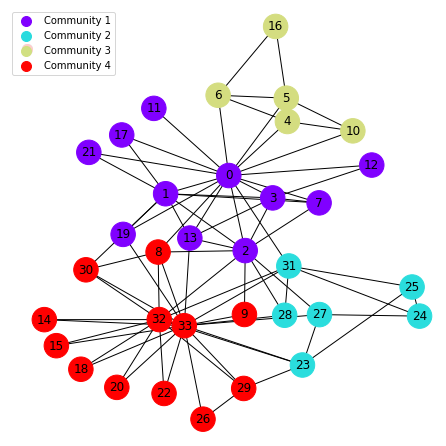

In [32]:
G = nx.Graph(A)
c_louvain = np.array(list(community_louvain.best_partition(G).values()))
_ = plt.figure(figsize=(6,6))
_ = nx.draw(G,node_color=c_louvain,labels={node:node for node in G.nodes()},node_size=600,cmap='rainbow',pos=nx.kamada_kawai_layout(G))
legend_elements = [plt.scatter([-0.55], [0.9], color=plt.cm.rainbow(0.001), label='Community 1',s=100),
                   plt.scatter([-0.55], [0.9], color=plt.cm.rainbow(0.33), label='Community 2',s=100),
                   plt.scatter([-0.55], [0.9], color=plt.cm.rainbow(0.66), label='Community 3',s=100),
                   plt.scatter([-0.55], [0.9], color=plt.cm.rainbow(0.99), label='Community 4',s=100)]
_ = plt.legend(loc='upper left')

The algorithm detects 4 communities

Louvain algorithm Community    =  [0 0 0 0 2 2 2 0 3 3 2 0 0 0 3 3 2 0 3 0 3 0 3 1 1 1 3 1 1 3 3 1 3 3]
Clauset-Newman-Moore community =  [2 1 1 1 2 2 2 1 0 1 2 2 1 1 0 0 2 1 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0]

ARI = 0.48739


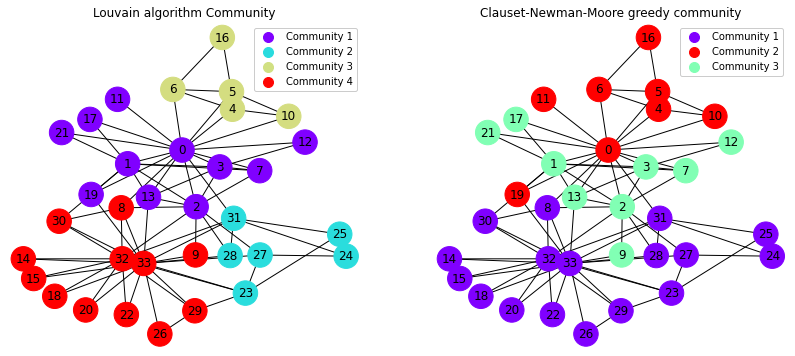

In [33]:
print("Louvain algorithm Community    = ",c_louvain)
print("Clauset-Newman-Moore community = ",c_array)
print()
print(f"ARI = {ARI(c_louvain,c_array):.5f}" )

fig,axs = plt.subplots(1,2,figsize=(14,6))
_ = axs[0].set_title("Louvain algorithm Community")
_ = nx.draw(G,node_color=c_louvain,labels={node:node for node in G.nodes()},node_size=600,cmap='rainbow',ax=axs[0],pos=nx.kamada_kawai_layout(G))
legend_elements = [plt.scatter([0.55], [0.9], color=plt.cm.rainbow(0.001), label='Community 1',s=100),
                   plt.scatter([0.55], [0.9], color=plt.cm.rainbow(0.33), label='Community 2',s=100),
                   plt.scatter([0.55], [0.9], color=plt.cm.rainbow(0.66), label='Community 3',s=100),
                   plt.scatter([0.55], [0.9], color=plt.cm.rainbow(0.99), label='Community 4',s=100)]
_ = axs[0].legend(handles=legend_elements,loc='upper right',framealpha=1)
_ = axs[1].set_title("Clauset-Newman-Moore greedy community")
_ = nx.draw(G,node_color=c_array,labels={node:node for node in G.nodes()},node_size=600,cmap='rainbow',ax=axs[1],pos=nx.kamada_kawai_layout(G))
legend_elements = [plt.scatter([0.55], [0.8], color=plt.cm.rainbow(0.001), label='Community 1',s=100),
                   plt.scatter([0.55], [0.8], color=plt.cm.rainbow(0.99), label='Community 2',s=100),
                   plt.scatter([0.55], [0.8], color=plt.cm.rainbow(0.5), label='Community 3',s=100)]
_ = plt.legend(handles=legend_elements,loc='upper right',framealpha=1)

If we compare the results from 2.3.2 we find a very similar result, at first glance the most important difference is the number of communities, the existance of community 2 in the Louvain algorithm is the biggest difference.

If we compare the algorithms used we find a very similar idea, they start by assigning one community to each of the nodes and then the communities are merged if they increase the modularity, the key difference is the use of a heap in the Clauset-Newman-Moore algorithm, the use of the heap is to always keep the more important merges first.  

## 3.2 Modularity maximisation with spectral partitioning
### 3.2.1 Bipartitioning algorithm

In [34]:
def get_subgraph(A, nodes):
    """ get the subgraph based on a list of nodes """
    A_subgraph = A[np.ix_(nodes,nodes)] 
    return A_subgraph

def get_laplacian(A):
    """ Get Laplacian of my network """
    n = len(A)
    D_1 = np.diag(np.sqrt(1/(A@np.ones(n))))
    return np.identity(n) - D_1 @ A @ D_1 

def get_spectral_partition(A):
    """ Compute spectral partition with Laplacian """
    n = len(A)
    spectral_partition = np.zeros(n)
    L = get_laplacian(A)
    eigenvals, eigenvecs = sp.linalg.eigh(L,eigvals=(1,1))
    spectral_partition[eigenvecs[:,0]>0] = 1
    return spectral_partition 

def get_modularity(A, partition):
    """ Compute the Modularity of partition with network """
    n = len(A)
    v = partition.reshape(n,1)
    d = (A@np.ones(n)).reshape(n,1)
    E = (1/2) * np.sum(d)
    R = (1/(2*E)) * (d@ d.T)
    H = np.concatenate([(v==k)*1 for k in np.unique(v)],axis=1)
    Q = (1/(2*E)) * np.trace((H.T)@ (A - R) @ H)
    return Q 

def set_new_partition(possible_partition, sub_partition, idx_nodes, comm_id):   
    """ Combine original partition with new subgraph partition """
    sub_partition[sub_partition==0] = comm_id
    sub_partition[sub_partition==1] = comm_id+1   
    possible_partition[idx_nodes] = sub_partition
    return possible_partition 

def bipartition(A):
    increasing_q = True

    # initial spectral partition
    partition = get_spectral_partition(A)
    Q = get_modularity(A, partition)
    print('Initial Q:', Q)
    comm_id = 0

    # loop over until modularity doesn't increase further
    while increasing_q:

        # define the original modularity
        Q_orig = Q

        # finding unique communities in partition
        unique_comms = np.unique(partition)   

        # loop over each community in the partition
        for comm in unique_comms:

            # make a copy of best partition so far  
            possible_partition = partition.copy()

            # find index of all nodes in community
            idx_nodes = np.where(partition==comm)[0]

            # get subgraph of graph
            A_sub = get_subgraph(A, idx_nodes)  

            # compute spectral partition of subgraph
            sub_partition = get_spectral_partition(A_sub)


            # iterating comm id
            comm_id += 2

            # define new partition
            possible_partition = set_new_partition(possible_partition, sub_partition, idx_nodes, comm_id)

            # compute modularity of new possible partition
            Q_new = get_modularity(A, possible_partition)  ## <-- EDIT THIS LINE

            # if the partition of subgraph improved modularity then keep it
            if Q_new>Q:
                partition = possible_partition.copy()
                print(f'Q = {Q_new}')
                Q = Q_new

        # break out of the while loop if modularity isn't increasing
        if not Q>Q_orig: 
            increasing_q = False
    n_part = np.unique(partition).shape[0]
    print('------------------')        
    print('Optimal number of clusters: {}'.format(n_part))
    
    simplify = {x:y for x,y in zip(np.unique(partition),list(range(n_part)))}
    partition = np.array([simplify[x] for x in partition])
    return(partition)

In [35]:
partition = bipartition(A)
print("Spectral bipartition Community = ",partition)

Initial Q: 0.3599605522682445
Q = 0.3744247205785667
Q = 0.3892176199868507
------------------
Optimal number of clusters: 4
Spectral bipartition Community =  [1 1 2 1 0 0 0 1 2 2 0 1 1 1 2 2 0 1 2 1 2 1 2 3 3 3 2 3 3 2 2 3 2 2]


### 3.2.2 Comparison of graph clustering

In [62]:
gt = pd.read_csv('ground_truth_karate_club.csv',index_col=0,names=['Group'],header=0)
gt['Id'] = pd.factorize(gt['Group'])[0]
display(gt['Group'].value_counts().to_frame())

,Group
Officer,17
Mr. Hi,17


In [96]:
methods = ['Ground Truth','CNM greedy','Spectral bipartition','Louvain algorithm','K neighbours']
dict_comunities = {'Ground Truth':np.array(gt['Id']),
                   'CNM greedy':c_array,
                   'Spectral bipartition':partition,
                   'Louvain algorithm':c_louvain,
                  'K neighbours':labels}
ARI_comparison = pd.DataFrame(columns=methods,index=methods)
for m1 in ARI_comparison.columns:
    for m2 in ARI_comparison.columns:
        ARI_comparison[m1][m2] = ARI(dict_comunities[m1],dict_comunities[m2])

Ground Truth                   =  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Clauset-Newman-Moore community =  [2 1 1 1 2 2 2 1 0 1 2 2 1 1 0 0 2 1 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Spectral bipartition Community =  [1 1 2 1 0 0 0 1 2 2 0 1 1 1 2 2 0 1 2 1 2 1 2 3 3 3 2 3 3 2 2 3 2 2]
Louvain algorithm Community    =  [0 0 0 0 2 2 2 0 3 3 2 0 0 0 3 3 2 0 3 0 3 0 3 1 1 1 3 1 1 3 3 1 3 3]
K neighbours                   =  [1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0]


        ARI:


,Ground Truth,CNM greedy,Spectral bipartition,Louvain algorithm,K neighbours
Ground Truth,1.0,0.568439,0.392372,0.464591,0.001297
CNM greedy,0.568439,1.0,0.430867,0.487392,-0.031487
Spectral bipartition,0.392372,0.430867,1.0,0.898602,-0.020209
Louvain algorithm,0.464591,0.487392,0.898602,1.0,-0.020327
K neighbours,0.001297,-0.031487,-0.020209,-0.020327,1.0


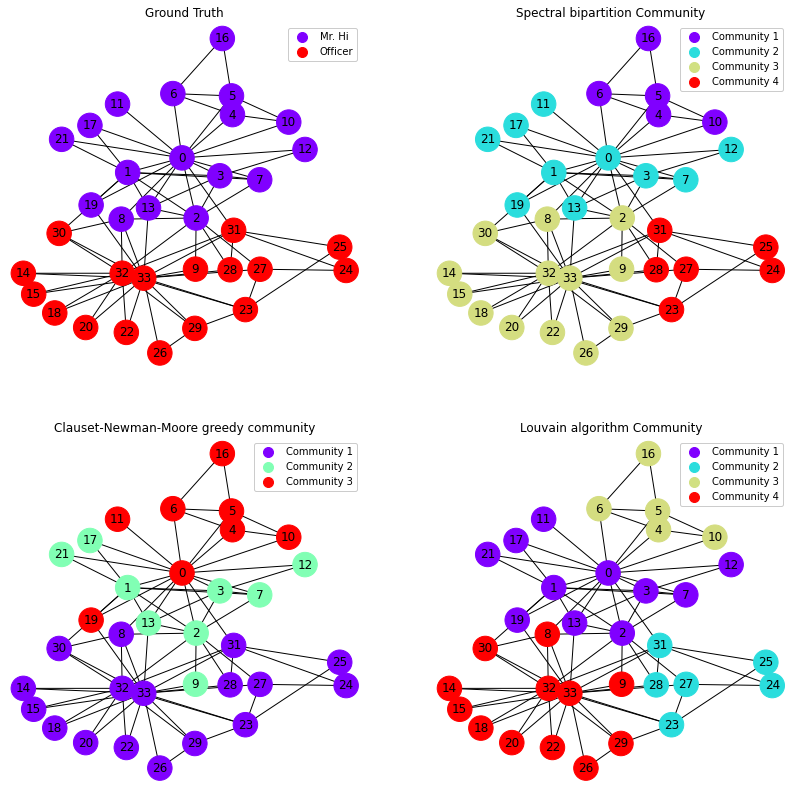

In [113]:
print("Ground Truth                   = ",np.array(gt['Id']))
print("Clauset-Newman-Moore community = ",c_array)
print("Spectral bipartition Community = ",partition)
print("Louvain algorithm Community    = ",c_louvain)
print("K neighbours                   = ",labels)

fig,axs = plt.subplots(2,2,figsize=(14,14))

_ = axs[0,0].set_title("Ground Truth")
_ = nx.draw(G,node_color=np.array(gt['Id']),labels={node:node for node in G.nodes()},node_size=600,cmap='rainbow',ax=axs[0,0],pos=nx.kamada_kawai_layout(G))
legend_elements = [axs[0,0].scatter([0.55], [0.9], color=plt.cm.rainbow(0.001), label='Mr. Hi',s=100),
                   axs[0,0].scatter([0.55], [0.9], color=plt.cm.rainbow(0.999), label='Officer',s=100)]
_ = axs[0,0].legend(handles=legend_elements,loc='upper right',framealpha=1)


_ = axs[1,0].set_title("Clauset-Newman-Moore greedy community")
_ = nx.draw(G,node_color=c_array,labels={node:node for node in G.nodes()},node_size=600,cmap='rainbow',ax=axs[1,0],pos=nx.kamada_kawai_layout(G))
legend_elements = [axs[1,0].scatter([0.55], [0.85], color=plt.cm.rainbow(0.001), label='Community 1',s=100),
                   axs[1,0].scatter([0.55], [0.85], color=plt.cm.rainbow(0.5), label='Community 2',s=100),
                   axs[1,0].scatter([0.55], [0.85], color=plt.cm.rainbow(0.99), label='Community 3',s=100)]
_ = axs[1,0].legend(handles=legend_elements,loc='upper right',framealpha=1)

_ = axs[0,1].set_title("Spectral bipartition Community")
_ = nx.draw(G,node_color=partition,labels={node:node for node in G.nodes()},node_size=600,cmap='rainbow',ax=axs[0,1],pos=nx.kamada_kawai_layout(G))
legend_elements = [axs[0,1].scatter([0.55], [0.85], color=plt.cm.rainbow(0.001), label='Community 1',s=100),
                   axs[0,1].scatter([0.55], [0.85], color=plt.cm.rainbow(0.333), label='Community 2',s=100),
                   axs[0,1].scatter([0.55], [0.85], color=plt.cm.rainbow(0.66), label='Community 3',s=100),
                   axs[0,1].scatter([0.55], [0.85], color=plt.cm.rainbow(0.99), label='Community 4',s=100)]
_ = axs[0,1].legend(handles=legend_elements,loc='upper right',framealpha=1)

_ = axs[1,1].set_title("Louvain algorithm Community")
_ = nx.draw(G,node_color=c_louvain,labels={node:node for node in G.nodes()},node_size=600,cmap='rainbow',ax=axs[1,1],pos=nx.kamada_kawai_layout(G))
legend_elements = [axs[1,1].scatter([0.55], [0.85], color=plt.cm.rainbow(0.001), label='Community 1',s=100),
                   axs[1,1].scatter([0.55], [0.85], color=plt.cm.rainbow(0.333), label='Community 2',s=100),
                   axs[1,1].scatter([0.55], [0.85], color=plt.cm.rainbow(0.66), label='Community 3',s=100),
                   axs[1,1].scatter([0.55], [0.85], color=plt.cm.rainbow(0.99), label='Community 4',s=100)]
_ = axs[1,1].legend(handles=legend_elements,loc='upper right',framealpha=1)
print()
print()
print("        ARI:")
display(ARI_comparison)

Comparing all of the analysis we have perform we can conclude that the Clauset-Newman-Moore community was the closest to the real clusters, we have an ARI of __0.56844__, comparing the other communities to each other we find that the spectral community and the Louvain community are very similar to each other with an ARI of __0.89__, as well as we use the Louvain to asign communities, we get a good result from using the spectral bipartion, we verify that computing the modularity of both algorithms:

In [108]:
print(f"Spectral bipartiton Modularity Q= {get_modularity(A, partition):.4f}",)
print(f"Louvain Modularity             Q= {get_modularity(A, c_louvain):.4f}")

Spectral bipartiton Modularity Q= 0.3892
Louvain Modularity             Q= 0.4198


In this example both algorithms perfomed very similar